### Analyze PFM Data

This notebook reads clustering states data and analyze it

In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import pydot
from IPython.display import Image
Path_XD = '/rugpfs/fs0/huds_lab/scratch/xdeng'
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
Today_Date = '20230823'

Total_params_file_name = 'SaturationbcK_ALL_datasets_Total_params_20230807.pkl'
Clusters_file_name = 'SaturationbcK_ALL_datasets_Clusters_6classWard_20230807.pkl'

Result_Date = '20230807'

TimeSpent_Date = '20230817'

In [3]:
with open(Path_XD+'/Clustering_States/FitParams/'+Total_params_file_name, 'rb') as f:
    # Load the contents of the file using pickle.load()
    Total_params = pickle.load(f) 

with open(Path_XD+'/Clustering_States/FitParams/'+Clusters_file_name, 'rb') as f:
    # Load the contents of the file using pickle.load()
    reclusters = pickle.load(f)

### Class Overview

In [109]:
Lc = []
Lc_n = []
Lc_std = []
Lc_sem = []
dLc_sem = []
for c in np.sort(pd.Series(reclusters).unique()):
    Lc.append(np.mean(Total_params[:,0][reclusters==c]))
    s = np.std(Total_params[:,0][reclusters==c], ddof=1)
    n = len(Total_params[:,0][reclusters==c])
    se = s / np.sqrt(n)
    Lc_std.append(s)
    Lc_sem.append(se)
    Lc_n.append(n)
    if c>1:
        dLc_sem.append(np.sqrt(Lc_std[c-1]**2/Lc_n[c-1] + s**2/n))
    

print('Lc', Lc)
print('dLc', np.diff(Lc))
print('Lc_sem', Lc_sem)
#rint('Lc_std', Lc_std)
print('n', Lc_n)
print('dLc_sem', dLc_sem)

Lc [38.21038523648432, 50.73058042556323, 80.6248674008676, 110.64538211615107, 128.20860834734452, 200.3751530692457]
dLc [12.52019519 29.89428698 30.02051472 17.56322623 72.16654472]
Lc_sem [0.1281359990415782, 0.2033613857354228, 0.5095789109885641, 0.9224460954487661, 1.4105748606308173, 4.227737324806961]
n [2314, 1826, 1372, 692, 585, 123]
dLc_sem [0.2875964297700214, 0.7206534070193397, 1.3045357787417518, 1.9948540986466399, 5.9789234628929515]


Text(0.5, 0, 'State')

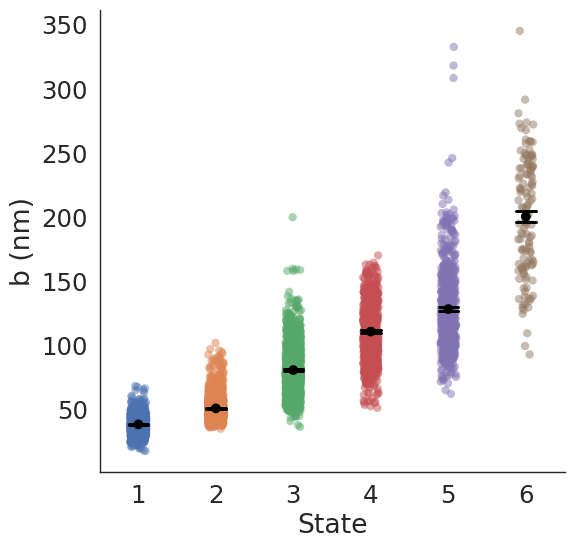

In [5]:
sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)  
df_b = pd.DataFrame(columns=['b','class'])
df_b['b'] = Total_params[:,0]
df_b['class'] = reclusters

plt.figure(figsize=(6,6))
ax=sns.stripplot(data=df_b, x="class", y="b", hue='class',size=6,palette='deep',alpha=0.5,legend=False)
plt.setp(ax.lines, zorder=100000)
plt.setp(ax.collections, zorder=100000, label="")
ax1=sns.pointplot(data=df_b, x="class", y="b", errorbar='se',join=False, capsize=0.25, color='black')
plt.setp(ax1.lines, zorder=1)
plt.setp(ax1.collections, zorder=1, label="")
sns.despine(top = True, right = True)
plt.ylabel('b (nm)')
plt.xlabel('State')
#plt.savefig(f'b of 6 classes {Today_Date}.svg', format='svg', dpi=1200)

### Functions

In [6]:
def load_n_preprocess(FileName, PorR, add_state_0=False):
    STATES = pd.read_csv(f'Results/ALL_Datasets_{Result_Date}/{Result_Date}_states_{PorR}_{FileName}_across_datasets_dev4_SaturationbcK.csv', index_col=[0])
    for i in range(6):
        for j in STATES.index:
            if str(STATES[f'seg{i}'][j]) != 'nan':
                STATES[f'seg{i}'][j] = int(str(STATES[f'seg{i}'][j])[1])

    for i in range(6):
        for j in STATES.index:
            if add_state_0:
                if i==0:
                    if str(STATES[f'seg{i}'][j]) != 'nan':
                        if STATES[f'OL_{i}?'][j] and STATES[f'seg{i}'][j]==1:
                        #print('get')
                            STATES[f'seg{i}'][j] = 0
                elif str(STATES[f'seg{i}'][j]) != 'nan':
                    if STATES[f'OL_{i}?'][j]:
                        #print('get')
                        STATES[f'seg{i}'][j] = np.nan
            else:
                if str(STATES[f'seg{i}'][j]) != 'nan':
                    if STATES[f'OL_{i}?'][j]:
                        #print('get')
                        STATES[f'seg{i}'][j] = np.nan

                        
    plot_states = STATES[['seg0', 'seg1', 'seg2', 'seg3', 'seg4', 'seg5']]
    plot_states.columns=['seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6']
    
    return STATES, plot_states


def ploting_states(plot_states, name, porr,add_state_0=False, savesvg=False):
    sns.set_theme(style='white')
    sns.set_context("paper", font_scale=2) 
    plt.figure(figsize=(10,6))
    if porr=='p':
        color='black'
    else:
        color='steelblue'
    for i, dataset in enumerate(np.asarray(plot_states)):
        #plt.plot(plot_states.columns, dataset, color=color, alpha=0.3,lw=3)
        
        if porr=='p':
            for j in range(len(dataset)-1):
                #plt.arrow(j, dataset[j], 1, (dataset[j+1]-dataset[j])/1, shape='full', width=0.03,lw=0, length_includes_head=True, head_width=.2,head_length=0.3, color=color, alpha=0.3)
                dydx=dataset[j+1]-dataset[j]
                if dydx==0:
                    plt.plot([j,j+1-0.336], [dataset[j],dataset[j+1]], color=color, alpha=0.3,lw=3.5)
                if dydx==1:
                    plt.plot([j,j+1-0.29], [dataset[j],dataset[j+1]-0.285*dydx], color=color, alpha=0.3,lw=3.5)
                if dydx==2:
                    plt.plot([j,j+1-0.218], [dataset[j],dataset[j+1]-0.213*dydx], color=color, alpha=0.3,lw=3.5)
                if dydx==3:
                    plt.plot([j,j+1-0.167], [dataset[j],dataset[j+1]-0.162*dydx], color=color, alpha=0.3,lw=3.5)
                if dydx==4:
                    plt.plot([j,j+1-0.135], [dataset[j],dataset[j+1]-0.13*dydx], color=color, alpha=0.3,lw=3.5)
                if dydx==-1:
                    continue
                    print(i)
                    plt.plot([j,j+1-0.29], [dataset[j],dataset[j+1]-0.285*dydx], color=color, alpha=0.3,lw=3.5)
                
                prop = dict(arrowstyle="-|>,head_width=0.32,head_length=1.8", lw=0,color=color,alpha=0.3, shrinkA=0, shrinkB=0)

                plt.annotate("", xy=(j+1,dataset[j+1]), xytext=(j, dataset[j]), arrowprops=prop)
   
    plt.xlim(-0.1,5.1)
    
    if add_state_0:
        plt.yticks(range(0, 6))
        plt.ylim(-0.1,5.1)
    else:
        plt.ylim(0.9,7.1)
        plt.yticks(range(1, 8))
        

    
    #plt.xticks(['seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6'])
    plt.xlabel('Segment')
    plt.ylabel('State')
    plt.title(f'{name}')
    #sns.despine(top = True, right = True, left = True, bottom=True)
    sns.despine(top = True, right = True)
    #plt.savefig(f'StatesAnalysis/States_{name}_{porr}')
    if savesvg:
        plt.savefig(Path_XD+f'/SVG_Files/clustering/{Today_Date}_transitionmap_{name}.svg', format='svg')
    plt.show()

In [7]:
def normalize_data(data, min_value, max_value, new_min, new_max):
    normalized_data = []
    for value in data:
        normalized_value = (value - min_value) * (new_max - new_min) / (max_value - min_value) + new_min
        normalized_data.append(normalized_value)
    return normalized_data

def ploting_states_thickness(plot_states, name, porr,add_state_0=False, savesvg=False):
    sns.set_theme(style='white')
    sns.set_context("paper", font_scale=2) 
    plt.figure(figsize=(10,6))
    
    data=[]
    
    if porr=='p':
        color='firebrick'
    else:
        color='steelblue'
        
    for i, dataset in enumerate(np.asarray(plot_states)):
        dataset = np.asarray(pd.Series(dataset).dropna())
        if porr=='p':
            for j in range(len(dataset)-1):
                data.append(str(j)+str(j+1)+str(dataset[j])+str(dataset[j+1]))
        else:
            for j in range(len(dataset)-1):
                data.append(str(j)+str(j+1)+str(dataset[j])+str(dataset[j+1]))
            
    data = pd.Series(data)
    
    d = data.value_counts().values
    #print(data.value_counts())
    d = normalize_data(d,min(d),max(d),0.5,6)
    
    df = pd.DataFrame(columns=['startx', 'starty', 'endx','endy','thickness'])
    df['thickness']=d
    for _, pos in enumerate(data.value_counts().index):
        df['startx'][_]=int(pos[0])
        df['starty'][_]=int(pos[2])
        df['endx'][_]=int(pos[1])
        df['endy'][_]=int(pos[3])
    
    #print(df)
    if porr=='p':
        for i in df.index:
            prop = dict(arrowstyle="-|>,head_width=0.32,head_length=1.8", lw=1,fc=color, ec='white', shrinkA=1, shrinkB=1)

            plt.annotate("", xy=(df['endx'][i],df['endy'][i]), xytext=(df['startx'][i], df['starty'][i]), arrowprops=prop)
    else:
        for i in df.index:
            prop = dict(arrowstyle="<|-,head_width=0.32,head_length=1.8", lw=1,fc=color, ec='white', shrinkA=1, shrinkB=1)

            plt.annotate("", xy=(df['endx'][i],df['endy'][i]), xytext=(df['startx'][i], df['starty'][i]), arrowprops=prop)
                 


    if porr=='p':
        for i in df.index:
            dydx=df['endy'][i]-df['starty'][i]

            if dydx==0:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.28], [df['starty'][i],df['endy'][i]], color=color,lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==1:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.3], [df['starty'][i],df['endy'][i]-0.3*dydx], color=color,lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==2:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.2], [df['starty'][i],df['endy'][i]-0.2*dydx], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==3:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.16], [df['starty'][i],df['endy'][i]-0.16*dydx], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==4:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.1], [df['starty'][i],df['endy'][i]-0.1*dydx], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==5:
                plt.plot([df['startx'][i],df['startx'][i]+1-0.05], [df['starty'][i],df['endy'][i]-0.05*dydx], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==-1:
                continue        

    else:
        for i in df.index:
            dydx=df['endy'][i]-df['starty'][i]

            if dydx==0:
                plt.plot([df['startx'][i]+0.28,df['startx'][i]+1], [df['starty'][i],df['endy'][i]], color=color,lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==1:
                plt.plot([df['startx'][i]+0.3,df['startx'][i]+1], [df['starty'][i]+0.3*dydx,df['endy'][i]], color=color,lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==2:
                plt.plot([df['startx'][i]+0.2,df['startx'][i]+1], [df['starty'][i]+0.2*dydx,df['endy'][i]], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==3:
                plt.plot([df['startx'][i]+0.16,df['startx'][i]+1], [df['starty'][i]+0.16*dydx,df['endy'][i]], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==4:
                plt.plot([df['startx'][i]+0.1,df['startx'][i]+1], [df['starty'][i]+0.1*dydx,df['endy'][i]], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==-1:
                plt.plot([df['startx'][i]+0.3,df['startx'][i]+1], [df['starty'][i]+0.3*dydx,df['endy'][i]], color=color,lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==-2:
                plt.plot([df['startx'][i]+0.2,df['startx'][i]+1], [df['starty'][i]+0.2*dydx,df['endy'][i]], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
            if dydx==-3:
                plt.plot([df['startx'][i]+0.16,df['startx'][i]+1], [df['starty'][i]+0.16*dydx,df['endy'][i]], color=color, lw=df['thickness'][i],  solid_capstyle='butt')
                
        
    plt.xlim(-0.1,5.1)
    
    if add_state_0:
        plt.yticks(range(0, 7))
        plt.ylim(-0.1,6.1)
    else:
        plt.ylim(0.9,6.1)
        plt.yticks(range(1, 7))
        

    
    #plt.xticks(['seg1', 'seg2', 'seg3', 'seg4', 'seg5', 'seg6'])
    plt.xlabel('Segment')
    plt.ylabel('State')
    plt.title(f'{name}')
    #sns.despine(top = True, right = True, left = True, bottom=True)
    sns.despine(top = True, right = True)
    #plt.savefig(f'StatesAnalysis/States_{name}_{porr}')
    if savesvg:
        plt.savefig(Path_XD+f'/SVG_Files/clustering/{Today_Date}_transitionmap_{name}.svg', format='svg')
    plt.show()

### Import data

In [89]:
Condition_List = ['WT 3 mM Ca\u00b2\u207a',
                  'WT 20 \u03BCM Ca\u00b2\u207a',
                  'WT 0 M Ca\u00b2\u207a',
                  'V507D 3 mM Ca\u00b2\u207a',
                  'V507D 20 \u03BCM Ca\u00b2\u207a',
                  'V507D 0 M Ca\u00b2\u207a']

File_WT_3mMCa = ['2020-02-12-s1b0-Dimer-3mMCa','2020-03-10-s0b1-Dimer-3mMCa','2020-12-16-s0b1-Dimer-3mMCa',
                 '2021-04-01-s0b0-Dimer-3mMCa','2022-04-21-s1b0-Dimer-3mMCa']

File_WT_20uMCa = ['2021-07-05-s2b0-Dimer-20uMCa','2021-07-07-s0b0-Dimer-20uMCa','2022-04-28-s0b3-Dimer-20uMCa',
                  '2022-04-28-s2b0-Dimer-20uMCa']

File_WT_0MCa = ['2022-05-03-s0b1-Dimer-0MCa', '2022-05-04-s0b0-Dimer-0MCa','2022-05-04-s0b1-Dimer-0MCa',
                '2022-10-24-s3b2-Dimer-0MCa','2022-10-24-s3b3-Dimer-0MCa','2022-12-13-s0b0-Dimer-0MCa']

File_V507D_3mMCa = ['2022-10-18-s1b1-V507DDimer-3mMCa','2022-10-18-s1b2-V507DDimer-3mMCa','2022-10-19-s2b0-V507DDimer-3mMCa',
                    '2022-10-20-s0b1-V507DDimer-3mMCa','2022-10-20-s1b0-V507DDimer-3mMCa','2022-11-01-s1b4-V507DDimer-3mMCa',
                    '2022-11-01-s2b0-V507DDimer-3mMCa','2023-05-19-s0b3-V507DDimer-3mMCa','2023-05-19-s1b0-V507DDimer-3mMCa',
                    '2023-05-19-s2b0-V507DDimer-3mMCa','2023-06-12-s1b0-V507DDimer-3mMCa','2023-06-13-s0b0-V507DDimer-3mMCa',
                    '2023-06-13-s1b1-V507DDimer-3mMCa','2023-06-14-s0b0-V507DDimer-3mMCa','2023-06-16-s0b0-V507DDimer-3mMCa',
                    '2023-06-16-s0b1-V507DDimer-3mMCa','2023-06-23-s1b0-V507DDimer-3mMCa','2023-06-23-s2b0-V507DDimer-3mMCa',
                    '2023-06-23-s2b2-V507DDimer-3mMCa','2023-06-27-s0b0-V507DDimer-3mMCa','2023-06-27-s0b1-V507DDimer-3mMCa',
                    '2023-06-27-s1b0-V507DDimer-3mMCa','2023-06-27-s1b1-V507DDimer-3mMCa','2023-06-28-s0b0-V507DDimer-3mMCa']

File_V507D_20uMCa = ['2022-11-09-s0b0-V507DDimer-20uMCa','2022-11-22-s1b0-V507DDimer-20uMCa','2022-12-16-s0b0-V507DDimer-20uMCa',
                     '2022-12-16-s1b0-V507DDimer-20uMCa','2023-02-01-s0b1-V507DDimer-20uMCa','2023-02-02-s0b1-V507DDimer-20uMCa',
                     '2023-02-02-s0b2-V507DDimer-20uMCa','2023-02-20-s0b3-V507DDimer-20uMCa','2023-03-01-s0b0-V507DDimer-20uMCa',
                     '2023-03-01-s0b2-V507DDimer-20uMCa','2023-03-01-s1b0-V507DDimer-20uMCa','2023-03-01-s1b2-V507DDimer-20uMCa',
                     '2023-05-10-s1b2-V507DDimer-20uMCa','2023-05-12-s0b1-V507DDimer-20uMCa','2023-05-12-s0b3-V507DDimer-20uMCa',
                     '2023-05-16-s0b2-V507DDimer-20uMCa']

File_V507D_0MCa = ['2022-12-19-s1b1-V507DDimer-0MCa','2022-12-19-s1b2-V507DDimer-0MCa','2023-03-07-s0b0-V507DDimer-0MCa',
                   '2023-03-07-s0b2-V507DDimer-0MCa']



FN_List = File_V507D_0MCa

Condition = Condition_List[5]


# mu - \u03BC
# Input the file name you wish to clusters together and their condition labels


### State transition map

In [90]:
STATES_pull = []
plot_states_pull = []
STATES_release = []
plot_states_release = []

for FN in FN_List:
    s_pull, ps_pull = load_n_preprocess(FN, PorR='Pull')
    s_release, ps_release = load_n_preprocess(FN, PorR='Release')
    STATES_pull.append(s_pull)
    plot_states_pull.append(ps_pull)
    STATES_release.append(s_release)
    plot_states_release.append(ps_release)

STATES_pull = pd.concat([*STATES_pull])
STATES_pull.index = range(len(STATES_pull.index))
plot_states_pull = pd.concat([*plot_states_pull])
plot_states_pull.index = range(len(plot_states_pull.index))
STATES_release = pd.concat([*STATES_release])
STATES_release.index = range(len(STATES_release.index))
plot_states_release = pd.concat([*plot_states_release])
plot_states_release.index = range(len(plot_states_release.index))


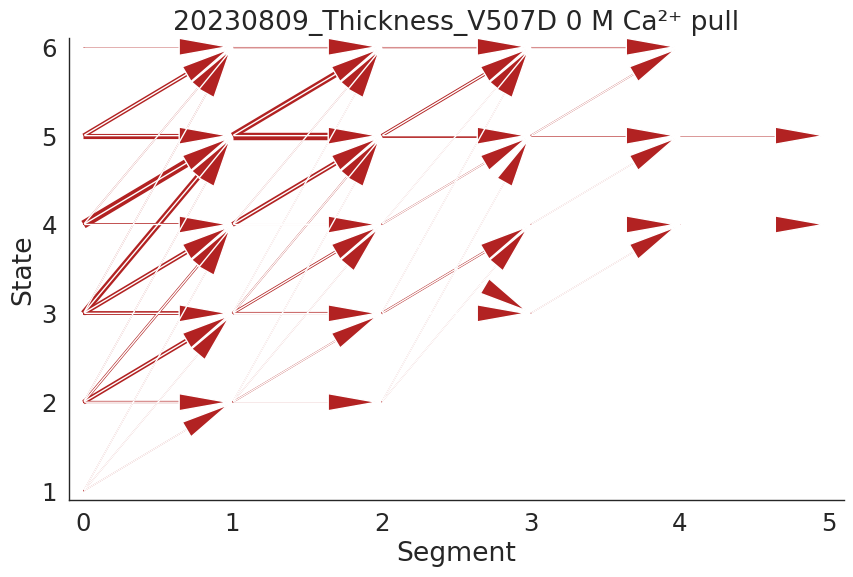

In [91]:
ploting_states_thickness(plot_states_pull, f'Thickness_{Condition} pull {Today_Date}', porr='p', savesvg=True)

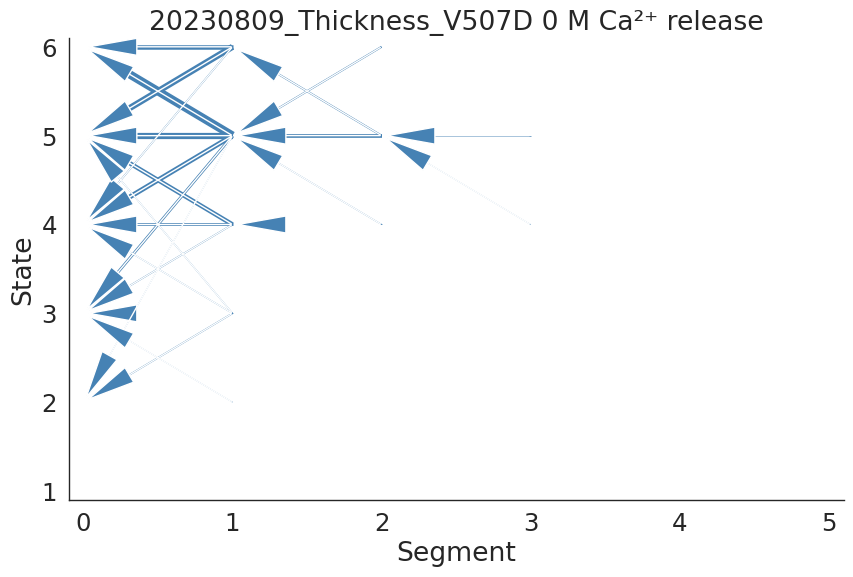

In [92]:
ploting_states_thickness(plot_states_release, f'Thickness_{Condition} release {Today_Date}', porr='r', savesvg=True)

### Unfolding Analysis

In [61]:
Jump_Size = []

size_key = ['1-2', '1-3', '1-4', '1-5', '1-6', 
            '2-3', '2-4', '2-5', '2-6', 
            '3-4', '3-5', '3-6', 
            '4-5', '4-6', 
            '5-6']
size_li = []
for i in range(len(Lc)):
    for j in range(i+1, len(Lc)):
        size_li.append(Lc[j]-Lc[i])
sizedic = dict(zip(size_key,size_li))


for i in plot_states_pull.index:
    traj = list(plot_states_pull.iloc[i][:].dropna()) + list(plot_states_release.iloc[i][:][::-1].dropna())
    js = []
    if len(traj)>1:
        for j in range(len(traj)-1):
            if (traj[j+1]-traj[j])>0:
                js.append(sizedic[f'{traj[j]}-{traj[j+1]}'])
    else:
        js = [0]
    Jump_Size.append(js)
    
    #Jump_Size.append(list(np.diff(list(plot_states_pull.iloc[i][:].dropna())+list(plot_states_release.iloc[i][:][::-1].dropna()))))
    #print(list(np.diff(list(plot_states_pull.iloc[i][:].dropna())+list(plot_states_release.iloc[i][:][::-1].dropna()))))

Sum_Jump_Size = []
F_Jump_Size = []
for i, size in enumerate(Jump_Size):
    if len(size) != 0:
        size=np.asarray(size)
        Sum_Jump_Size.append(sum(size[size>=0]))
    else:
        Sum_Jump_Size.append(0)
    for j in size:
        F_Jump_Size.append(j)
F_Jump_Size = np.asarray(F_Jump_Size)

NameError: name 'plot_states_pull' is not defined

In [ ]:
sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)    
sns.histplot(F_Jump_Size, color='darksalmon', binwidth=5)
plt.xlabel('Magnitude of Positive State Transition (nm)')
plt.title(f'{Condition}')
#plt.xticks([1,2,3])
plt.xlim(-5,160)
plt.xticks([0,35,70,105,140])
sns.despine(top = True, right = True)
print('Average Unfold Size =', np.mean(F_Jump_Size[F_Jump_Size>0]), 'STD =', np.std(F_Jump_Size[F_Jump_Size>0]), 'N =', len(F_Jump_Size[F_Jump_Size>0]))

In [ ]:
sns.histplot(Sum_Jump_Size, color='lightcoral', binwidth=5)
plt.xlabel('Magnitude of Positive State Transition per Trajectory (nm)')
plt.title(f'{Condition}')
plt.xticks([0,35,70,105,140])
plt.xlim(-5,160)
sns.despine(top = True, right = True)
print('Average Unfold Size per Trajectory =', np.mean(Sum_Jump_Size), 'STD =', np.std(Sum_Jump_Size), 'N =', len(Sum_Jump_Size))

### Refold Analysis

In [ ]:
size_key = ['1-2', '1-3', '1-4', '1-5', '1-6', 
            '2-3', '2-4', '2-5', '2-6', 
            '3-4', '3-5', '3-6', 
            '4-5', '4-6', 
            '5-6']
size_li = []
for i in range(len(Lc)):
    for j in range(i+1, len(Lc)):
        size_li.append(Lc[j]-Lc[i])
sizedic = dict(zip(size_key,size_li))


refold = pd.DataFrame(index=plot_states_release.index[:-1], columns=['size', 'Ifto12', 'Unfolded'])

unfoldcount=0
unfoldmax=[]
cycletorefoldto12 = 0
ct12=[]

for i in plot_states_release.index[:-1]:
    unfolded=False
    
    if plot_states_pull['seg1'][i] == 1 or plot_states_pull['seg1'][i] == 2:
        if cycletorefoldto12>0:
            #print(cycletorefoldto12)
            ct12.append(cycletorefoldto12)
        cycletorefoldto12 = 0
        unfoldcount=0
        unfoldmax=[]
    
    unfoldcount += len(plot_states_pull.iloc[i].dropna()) + len(plot_states_release.iloc[i].dropna()) - 2
    
    if len(pd.Series(list(plot_states_pull.iloc[i].dropna())+list(plot_states_release.iloc[i].dropna())).unique()) > 1:
        if max(plot_states_release.iloc[i]) >= max(plot_states_pull.iloc[i]):
            unfoldmax.append(max(max(plot_states_pull.iloc[i]), max(plot_states_release.iloc[i])))
    
    if len(unfoldmax)>0:
        if unfoldcount > 0 and max(unfoldmax)>2:
            refold['Unfolded'][i] = True
            unfolded=True
            #print('yes',i)
    
    if unfolded:
        cycletorefoldto12+=1
        fs = max(max(plot_states_pull.iloc[i]), max(plot_states_release.iloc[i]))
        ls = plot_states_pull['seg1'][i+1]
        if fs - ls>0:
            refold['size'][i] = sizedic[f'{ls}-{fs}']
        else:
            refold['size'][i] = 0
        if (plot_states_pull['seg1'][i+1] == 1 or plot_states_pull['seg1'][i+1] == 2):
            refold['Ifto12'][i] = True
            #print('refoldto12')
        else:
            refold['Ifto12'][i] = False
            
    else:
        refold['size'][i]=np.nan
        refold['Ifto12'][i] = np.nan
    
    

refold_rate = len(np.where(refold['size']>12)[0])/len(np.where(refold['Unfolded']==True)[0])
refold_to12_rate = len(np.where(refold['Ifto12']==True)[0])/len(np.where(refold['Unfolded']==True)[0])
avg_cycle_to12 = np.mean(ct12)

print('refold_to_12_rate=', refold_to12_rate, 'avg_cycle_to12', avg_cycle_to12)

In [ ]:
sns.histplot(refold['size'], color='steelblue', binwidth=5)
plt.xlabel('Magnitude of Negative State Transition (nm)')
plt.title(f'{Condition}')
plt.xticks([0,35,70,105,140])
plt.xlim(-5,160)
sns.despine(top = True, right = True)
print('Average Refold Size =', np.mean(refold['size']), 'STD =', np.std(refold['size']), 'N =', len(refold['size'].dropna()))

#### Plot all refold data

In [93]:
rr=[]
rr12=[]
cto12=[]

for a in FN_List:
    print(a)

    FN_List_ = [a]

    Condition = ''


    STATES_pull = []
    plot_states_pull = []
    STATES_release = []
    plot_states_release = []

    for FN in FN_List_:
        s_pull, ps_pull = load_n_preprocess(FN, PorR='Pull')
        s_release, ps_release = load_n_preprocess(FN, PorR='Release')
        STATES_pull.append(s_pull)
        plot_states_pull.append(ps_pull)
        STATES_release.append(s_release)
        plot_states_release.append(ps_release)

    STATES_pull = pd.concat([*STATES_pull])
    STATES_pull.index = range(len(STATES_pull.index))
    plot_states_pull = pd.concat([*plot_states_pull])
    plot_states_pull.index = range(len(plot_states_pull.index))
    STATES_release = pd.concat([*STATES_release])
    STATES_release.index = range(len(STATES_release.index))
    plot_states_release = pd.concat([*plot_states_release])
    plot_states_release.index = range(len(plot_states_release.index))
    print(len(plot_states_release.index))
    sizedic = {'1-2':12.52, '1-3':42.41, '1-4':72.43, '1-5':89.99, '1-6':162.16,
              '2-3':29.89, '2-4':59.91, '2-5':77.47, '2-6':149.64, 
              '3-4':30.02, '3-5':47.58, '3-6':119.75, 
              '4-5':17.56, '4-6':89.73, 
              '5-6':72.17}

    refold = pd.DataFrame(index=plot_states_release.index[:-1], columns=['size', 'Ifto12', 'Unfolded'])


    unfoldcount=0
    unfoldmax=[]
    cycletorefoldto12 = 0
    ct12=[]

    for i in plot_states_release.index[:-1]:
        unfolded=False

        if plot_states_pull['seg1'][i] == 1 or plot_states_pull['seg1'][i] == 2:
            if cycletorefoldto12>0:
                #print(cycletorefoldto12)
                ct12.append(cycletorefoldto12)
            cycletorefoldto12 = 0
            unfoldcount=0
            unfoldmax=[]

        unfoldcount += len(plot_states_pull.iloc[i].dropna()) + len(plot_states_release.iloc[i].dropna()) - 2

        if len(pd.Series(list(plot_states_pull.iloc[i].dropna())+list(plot_states_release.iloc[i].dropna())).unique()) > 1:
            if max(plot_states_release.iloc[i]) >= max(plot_states_pull.iloc[i]):
                unfoldmax.append(max(max(plot_states_pull.iloc[i]), max(plot_states_release.iloc[i])))

        if len(unfoldmax)>0:
            if unfoldcount > 0 and max(unfoldmax)>2:
                refold['Unfolded'][i] = True
                unfolded=True
                #print('yes',i)

        if unfolded:
            cycletorefoldto12+=1
            fs = max(max(plot_states_pull.iloc[i]), max(plot_states_release.iloc[i]))
            ls = plot_states_pull['seg1'][i+1]
            if fs - ls>0:
                refold['size'][i] = sizedic[f'{ls}-{fs}']
            else:
                refold['size'][i] = 0
            if (plot_states_pull['seg1'][i+1] == 1 or plot_states_pull['seg1'][i+1] == 2):
                refold['Ifto12'][i] = True
                #print('refoldto12')
            else:
                refold['Ifto12'][i] = False

        else:
            refold['size'][i]=np.nan
            refold['Ifto12'][i] = np.nan


    if len(np.where(refold['Unfolded']==True)[0])==0:
        print('no unfolding')
        refold_rate=1.0
        refold_to12_rate= 1.0
        avg_cycle_to12= 1.0
    else:
        refold_rate = len(np.where(refold['size']>12.52)[0])/len(np.where(refold['Unfolded']==True)[0])
        refold_to12_rate = len(np.where(refold['Ifto12']==True)[0])/len(np.where(refold['Unfolded']==True)[0])
        if len(ct12)==0:
            avg_cycle_to12 = len(plot_states_release.index)
        else:
            avg_cycle_to12 = np.mean(ct12)
    
    rr.append(refold_rate)
    rr12.append(refold_to12_rate)
    cto12.append(avg_cycle_to12)

    print('refold_rate=', refold_rate, 'refold_to_12_rate=', refold_to12_rate, 'avg_cycle_to12', avg_cycle_to12)
print(rr,rr12,cto12)

2022-12-19-s1b1-V507DDimer-0MCa
81
refold_rate= 0.9367088607594937 refold_to_12_rate= 0.12658227848101267 avg_cycle_to12 6.4
2022-12-19-s1b2-V507DDimer-0MCa
234
refold_rate= 0.8626609442060086 refold_to_12_rate= 0.11587982832618025 avg_cycle_to12 7.666666666666667
2023-03-07-s0b0-V507DDimer-0MCa
51
refold_rate= 0.64 refold_to_12_rate= 0.0 avg_cycle_to12 51
2023-03-07-s0b2-V507DDimer-0MCa
69
refold_rate= 0.95 refold_to_12_rate= 0.7166666666666667 avg_cycle_to12 1.3333333333333333
[0.9367088607594937, 0.8626609442060086, 0.64, 0.95] [0.12658227848101267, 0.11587982832618025, 0.0, 0.7166666666666667] [6.4, 7.666666666666667, 51, 1.3333333333333333]


Text(0.5, 1.0, 'Percentage of cycles with refolding')

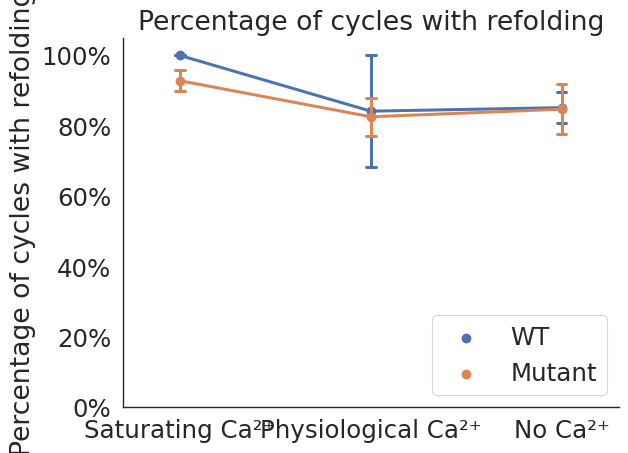

In [110]:
df_all_refold = pd.DataFrame(columns=['Ca2+','Construct','refold_rate','refold_to_12_rate','avg_cycle_to12'])
df_all_refold['Ca2+'] = ['Saturating Ca\u00b2\u207a']*len(File_WT_3mMCa)+['Physiological Ca\u00b2\u207a']*len(File_WT_20uMCa) + ['No Ca\u00b2\u207a']*len(File_WT_0MCa) + ['Saturating Ca\u00b2\u207a']*len(File_V507D_3mMCa) + ['Physiological Ca\u00b2\u207a']*len(File_V507D_20uMCa) + ['No Ca\u00b2\u207a']*len(File_V507D_0MCa)
df_all_refold['Construct'] = ['WT']*(len(File_WT_3mMCa)+len(File_WT_20uMCa)+len(File_WT_0MCa)) + ['Mutant']*(len(File_V507D_3mMCa)+len(File_V507D_20uMCa)+len(File_V507D_0MCa))


# Copy the printout from last cells here

df_all_refold['refold_rate'] = [1,1,1,1,1,
                                1,1,0.3670886075949367,1,
                               0.8644859813084113,0.7857142857142857,0.7027027027027027,1,0.8181818181818182,0.9396984924623115,
                               0.9316770186335404, 1.0, 0.8, 1.0, 0.9402985074626866, 1.0, 0.9767441860465116, 1.0, 0.7857142857142857, 0.3333333333333333, 0.9743589743589743, 1.0, 1.0, 1.0, 1.0, 0.9545454545454546, 1.0, 1.0, 1.0, 0.8936170212765957, 1.0, 0.7464788732394366, 0.9398907103825137, 1.0,
                               0.9090909090909091, 0.9661016949152542, 0.3022222222222222, 1.0, 0.8867924528301887, 1.0, 0.9791666666666666, 0.8493150684931506, 0.7560975609756098, 0.9411764705882353, 0.3096085409252669, 0.8837209302325582, 0.8023255813953488, 0.75, 1.0, 0.8775510204081632,
                               0.9367088607594937, 0.8626609442060086, 0.64, 0.95]
df_all_refold['refold_to_12_rate'] = [1,1,1,1,1,
                                      1,1,0.3670886075949367,1,
                                     0.7990654205607477,0.2857142857142857,0.6216216216216216,0.9,0.8181818181818182,0.35175879396984927,
                                     0.8385093167701864, 1.0, 0.02, 0.9708029197080292, 0.9104477611940298, 1.0, 0.46511627906976744, 1.0, 0.7857142857142857, 0.3333333333333333, 0.7435897435897436, 1.0, 1.0, 1.0, 1.0, 0.9545454545454546, 1.0, 1.0, 1.0, 0.7872340425531915, 1.0, 0.23943661971830985, 0.6721311475409836, 1.0,
                                     0.09090909090909091, 0.9661016949152542, 0.28, 1.0, 0.07547169811320754, 0.42105263157894735, 0.9652777777777778, 0.4520547945205479, 0.6829268292682927, 0.5294117647058824, 0.2491103202846975, 0.6046511627906976, 0.7906976744186046, 0.5, 1.0, 0.8843537414965986,
                                     0.12658227848101267, 0.11587982832618025, 0.0, 0.7166666666666667]

df_all_refold['avg_cycle_to12'] = [1,1,1,1,1,
                                  1,1,2.5517241379310347,1,
                                  1.2514619883040936,2.875,1.565217391304348,1.125,1.2222222222222223,2.8260869565217392,
                                  1.1940298507462686, 1.0, 9.0, 1.0303030303030303, 1.1, 1.0, 2.1052631578947367, 1.0, 1.2727272727272727, 3.0, 1.2758620689655173, 1.0, 1.0, 1.0, 1.0, 1.0476190476190477, 1.0, 1.0, 1.0, 1.2702702702702702, 1.0, 4.102941176470588, 1.4918032786885247, 1.0,
                                  2.0, 1.0350877192982457, 3.6129032258064515, 1.0, 13.0, 2.3333333333333335, 1.036231884057971, 1.9696969696969697, 1.4444444444444444, 1.6666666666666667, 4.043478260869565, 1.5769230769230769, 1.2647058823529411, 2.0, 1.0, 1.1317829457364341,
                                  6.4, 7.666666666666667, 51, 1.3333333333333333]

#refoldrate
ax = sns.pointplot(data=df_all_refold, x='Ca2+',y='refold_rate',hue='Construct',capsize=.05, errorbar='se')
plt.ylim(0,1.05)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('')
plt.ylabel('Percentage of cycles with refolding')
plt.legend(loc='lower right')
sns.despine(top = True, right = True)
plt.xlim(-0.3,2.3)
plt.title('Percentage of cycles with refolding')
#plt.savefig(f'{Today_Date}_Percentage of cycles with refolding.png')

In [116]:
r=[1,1,1,1,1,
 1,1,0.3670886075949367,1,
 0.7990654205607477,0.2857142857142857,0.6216216216216216,0.9,0.8181818181818182,0.35175879396984927,
 0.8385093167701864, 1.0, 0.02, 0.9708029197080292, 0.9104477611940298, 1.0, 0.46511627906976744, 1.0, 0.7857142857142857, 0.3333333333333333, 0.7435897435897436, 1.0, 1.0, 1.0, 1.0, 0.9545454545454546, 1.0, 1.0, 1.0, 0.7872340425531915, 1.0, 0.23943661971830985, 0.6721311475409836, 1.0,
 0.09090909090909091, 0.9661016949152542, 0.28, 1.0, 0.07547169811320754, 0.42105263157894735, 0.9652777777777778, 0.4520547945205479, 0.6829268292682927, 0.5294117647058824, 0.2491103202846975, 0.6046511627906976, 0.7906976744186046, 0.5, 1.0, 0.8843537414965986,
 0.12658227848101267, 0.11587982832618025, 0.0, 0.7166666666666667]

r12 = [0.12658227848101267, 0.11587982832618025, 0.0, 0.7166666666666667]
se = np.std(r12, ddof=1) / np.sqrt(len(r12))
print(np.mean(r12), se, len(r12))

0.2397821933684649 0.16152407403725025 4


Text(0.5, 1.0, 'average cycle to full refolding')

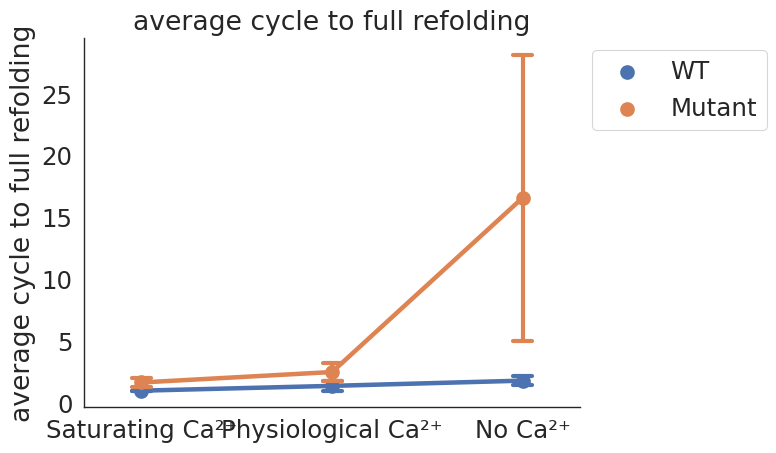

In [99]:
#cycle to12
ax = sns.pointplot(data=df_all_refold, x='Ca2+',y='avg_cycle_to12',hue='Construct',capsize=.1,errorbar='se',scale=1.5,errwidth=3)

plt.xlabel('')
plt.ylabel('average cycle to full refolding')
plt.legend(loc='upper right')
sns.despine(top = True, right = True)
plt.xlim(-0.3,2.3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('average cycle to full refolding')
#plt.savefig(f'{Today_Date}_Percentage of cycles with fully refolding.png')

Text(0.5, 1.0, 'Percentage of cycles with fully refolding')

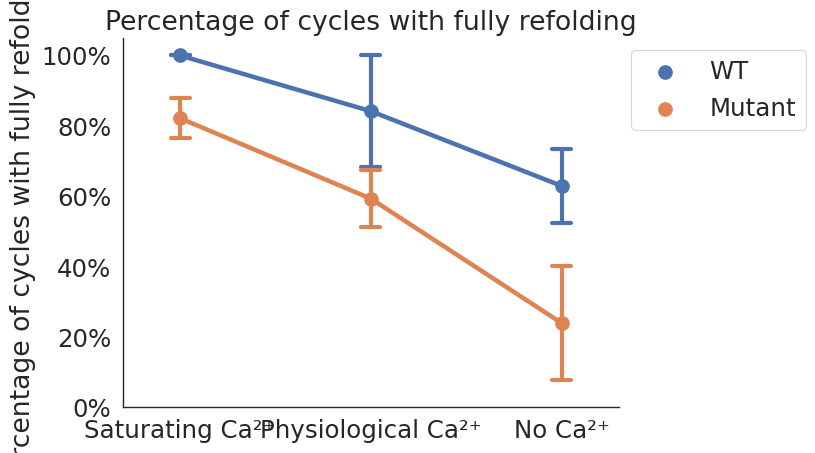

In [103]:
#refoldto12rate
ax = sns.pointplot(data=df_all_refold, x='Ca2+',y='refold_to_12_rate',hue='Construct',capsize=.1,errorbar='se',scale=1.5,errwidth=3)
plt.ylim(0,1.05)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('')
plt.ylabel('Percentage of cycles with fully refolding')
plt.legend(loc='upper right')
sns.despine(top = True, right = True)
plt.xlim(-0.3,2.3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Percentage of cycles with fully refolding')
#plt.savefig(f'{Today_Date}_Percentage of cycles with fully refolding.png')

In [ ]:
# For all individual ct12 data

#WT20ct12 = np.asarray(ct12)*2
#WT0ct12 = np.asarray(ct12)*2
##Mutant3ct12 = np.asarray(ct12)*2
#Mutant20ct12 = np.asarray(ct12)*2
##Mutant0ct12 = np.asarray(ct12)*2

"""timeto12 = [[np.nan],WT20ct12,WT0ct12,Mutant3ct12,Mutant20ct12,Mutant0ct12]
df_timeto12 = pd.DataFrame(columns=['Ca2+','Construct','time_to12'])

df_timeto12['Ca2+'] = ['High Ca\u00b2\u207a']*1 + ['Physiological Ca\u00b2\u207a']*len(WT20ct12) + ['No Ca\u00b2\u207a']*len(WT0ct12) + ['High Ca\u00b2\u207a']*len(Mutant3ct12) + ['Physiological Ca\u00b2\u207a']*len(Mutant20ct12) + ['No Ca\u00b2\u207a']*len(Mutant0ct12)

df_timeto12['Construct'] = ['WT']*(1+len(WT20ct12)+len(WT0ct12)) + ['Mutant']*(len(Mutant3ct12)+len(Mutant20ct12)+len(Mutant0ct12))

df_timeto12['time_to12'] = [i for j in timeto12 for i in j]
df_timeto12"""

In [ ]:
"""timeto12 = [WT20ct12,WT0ct12,Mutant20ct12,Mutant0ct12]
df_timeto12 = pd.DataFrame(columns=['Ca2+','Construct','time_to12'])

df_timeto12['Ca2+'] =  ['Physiological Ca\u00b2\u207a']*len(WT20ct12) + ['No Ca\u00b2\u207a']*len(WT0ct12)  + ['Physiological Ca\u00b2\u207a']*len(Mutant20ct12) + ['No Ca\u00b2\u207a']*len(Mutant0ct12)

df_timeto12['Construct'] = ['WT']*(len(WT20ct12)+len(WT0ct12)) + ['Mutant']*(len(Mutant20ct12)+len(Mutant0ct12))

df_timeto12['time_to12'] = [i for j in timeto12 for i in j]
df_timeto12"""

In [ ]:
"""ax = sns.pointplot(data=df_timeto12, x='Ca2+',y='time_to12',hue='Construct',capsize=.1,errorbar='se',scale=1.5,errwidth=3)

plt.xlabel('')
plt.ylabel('Fully refolding time during resting phase (s)')
plt.legend(loc='upper left')
sns.despine(top = True, right = True)
#plt.xlim(-0.3,2.3)

#plt.title('Fully refolding time during resting phase')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.savefig(f'{Today_Date}_Fully refolding time during resting phase.png')"""

### Time Spending and Markov Process

In [244]:
Condition_List = ['WT 3 mM Ca\u00b2\u207a',
                  'WT 20 \u03BCM Ca\u00b2\u207a',
                  'WT 0 M Ca\u00b2\u207a',
                  'V507D 3 mM Ca\u00b2\u207a',
                  'V507D 20 \u03BCM Ca\u00b2\u207a',
                  'V507D 0 M Ca\u00b2\u207a']

File_WT_3mMCa = ['2020-02-12-s1b0-Dimer-3mMCa','2020-03-10-s0b1-Dimer-3mMCa','2020-12-16-s0b1-Dimer-3mMCa',
                 '2021-04-01-s0b0-Dimer-3mMCa','2022-04-21-s1b0-Dimer-3mMCa']

File_WT_20uMCa = ['2021-07-05-s2b0-Dimer-20uMCa','2021-07-07-s0b0-Dimer-20uMCa','2022-04-28-s0b3-Dimer-20uMCa',
                  '2022-04-28-s2b0-Dimer-20uMCa']

File_WT_0MCa = ['2022-05-03-s0b1-Dimer-0MCa', '2022-05-04-s0b0-Dimer-0MCa','2022-05-04-s0b1-Dimer-0MCa',
                '2022-10-24-s3b2-Dimer-0MCa','2022-10-24-s3b3-Dimer-0MCa','2022-12-13-s0b0-Dimer-0MCa']

File_V507D_3mMCa = ['2022-10-18-s1b1-V507DDimer-3mMCa','2022-10-18-s1b2-V507DDimer-3mMCa','2022-10-19-s2b0-V507DDimer-3mMCa',
                    '2022-10-20-s0b1-V507DDimer-3mMCa','2022-10-20-s1b0-V507DDimer-3mMCa','2022-11-01-s1b4-V507DDimer-3mMCa',
                    '2022-11-01-s2b0-V507DDimer-3mMCa','2023-05-19-s0b3-V507DDimer-3mMCa','2023-05-19-s1b0-V507DDimer-3mMCa',
                    '2023-05-19-s2b0-V507DDimer-3mMCa','2023-06-12-s1b0-V507DDimer-3mMCa','2023-06-13-s0b0-V507DDimer-3mMCa',
                    '2023-06-13-s1b1-V507DDimer-3mMCa','2023-06-14-s0b0-V507DDimer-3mMCa','2023-06-16-s0b0-V507DDimer-3mMCa',
                    '2023-06-16-s0b1-V507DDimer-3mMCa','2023-06-23-s1b0-V507DDimer-3mMCa','2023-06-23-s2b0-V507DDimer-3mMCa',
                    '2023-06-23-s2b2-V507DDimer-3mMCa','2023-06-27-s0b0-V507DDimer-3mMCa','2023-06-27-s0b1-V507DDimer-3mMCa',
                    '2023-06-27-s1b0-V507DDimer-3mMCa','2023-06-27-s1b1-V507DDimer-3mMCa','2023-06-28-s0b0-V507DDimer-3mMCa']

File_V507D_20uMCa = ['2022-11-09-s0b0-V507DDimer-20uMCa','2022-11-22-s1b0-V507DDimer-20uMCa','2022-12-16-s0b0-V507DDimer-20uMCa',
                     '2022-12-16-s1b0-V507DDimer-20uMCa','2023-02-01-s0b1-V507DDimer-20uMCa','2023-02-02-s0b1-V507DDimer-20uMCa',
                     '2023-02-02-s0b2-V507DDimer-20uMCa','2023-02-20-s0b3-V507DDimer-20uMCa','2023-03-01-s0b0-V507DDimer-20uMCa',
                     '2023-03-01-s0b2-V507DDimer-20uMCa','2023-03-01-s1b0-V507DDimer-20uMCa','2023-03-01-s1b2-V507DDimer-20uMCa',
                     '2023-05-10-s1b2-V507DDimer-20uMCa','2023-05-12-s0b1-V507DDimer-20uMCa','2023-05-12-s0b3-V507DDimer-20uMCa',
                     '2023-05-16-s0b2-V507DDimer-20uMCa']

File_V507D_0MCa = ['2022-12-19-s1b1-V507DDimer-0MCa','2022-12-19-s1b2-V507DDimer-0MCa','2023-03-07-s0b0-V507DDimer-0MCa',
                   '2023-03-07-s0b2-V507DDimer-0MCa']



FN_List = File_V507D_20uMCa

Condition = Condition_List[4]


Total_SEG_P = []
Total_SEG_R = []

for FN in FN_List:
    
    with open(f'Processed_Seg/PullSeg_{FN}_dev4.pkl', 'rb') as f:
        # Load the contents of the file using pickle.load()
        Total_SEG_P.append(pickle.load(f))

    with open(f'Processed_Seg/ReleaseSeg_{FN}_dev4.pkl', 'rb') as f:
        # Load the contents of the file using pickle.load()
        Total_SEG_R.append(pickle.load(f))

In [245]:
import warnings
warnings.filterwarnings("ignore")
STATES_pull_dropna = []
STATES_release_dropna = []
STATES_SEG_P = []
STATES_SEG_R = []

def load_n_preprocess_OL(FileName, ind, PorR, add_state_0=False):
    STATES = pd.read_csv(f'Results/ALL_Datasets_{Result_Date}/{Result_Date}_states_{PorR}_{FileName}_across_datasets_dev4_SaturationbcK.csv', index_col=[0])
    for i in range(6):
        for j in STATES.index:
            if str(STATES[f'seg{i}'][j]) != 'nan':
                STATES[f'seg{i}'][j] = int(str(STATES[f'seg{i}'][j])[1])

    OL = STATES[['OL_0?', 'OL_1?', 'OL_2?', 'OL_3?', 'OL_4?', 'OL_5?']]
    
    ol = []
    for i in OL.index:
        ol.append(OL.iloc[i].any())
    
    STATES = STATES.iloc[~np.asarray(ol)]
    
    STATES_SEG = pd.DataFrame(columns=['state_seg0','seg0','state_seg1','seg1','state_seg2','seg2','state_seg3','seg3','state_seg4','seg4','state_seg5','seg5'], index=STATES.index)

    for i in STATES_SEG.index:
        for j in range(6):
            STATES_SEG[f'state_seg{j}'][i] = STATES[f'seg{j}'][i]
            if PorR == 'Pull':
                if j < len(Total_SEG_P[ind][i]):
                    STATES_SEG[f'seg{j}'][i] = Total_SEG_P[ind][i][j]
            else:
                if j < len(Total_SEG_R[ind][i]):
                    STATES_SEG[f'seg{j}'][i] = Total_SEG_R[ind][i][j]
    
    
    return STATES, STATES_SEG

for ind, FN in enumerate(FN_List):
    spd, ssp = load_n_preprocess_OL(FN, ind, PorR='Pull')
    srd, ssr = load_n_preprocess_OL(FN, ind, PorR='Release')
    STATES_pull_dropna.append(spd)
    STATES_release_dropna.append(srd)
    STATES_SEG_P.append(ssp)
    STATES_SEG_R.append(ssr)




In [246]:
STATES_pull_dropna = pd.concat([*STATES_pull_dropna])
STATES_pull_dropna.index = range(len(STATES_pull_dropna))
STATES_release_dropna = pd.concat([*STATES_release_dropna])
STATES_release_dropna.index = range(len(STATES_release_dropna))
STATES_SEG_P = pd.concat([*STATES_SEG_P])
STATES_SEG_P.index = range(len(STATES_SEG_P))
STATES_SEG_R = pd.concat([*STATES_SEG_R])
STATES_SEG_R.index = range(len(STATES_SEG_R))

#### Time Spending

In [87]:
df_time = pd.DataFrame(0, index=STATES_pull_dropna.index, columns=['state1', 'state2', 'state3', 'state4', 'state5', 'state6'])
for i in range(6):
    for j in STATES_pull_dropna.index:
        if str(STATES_pull_dropna[f'seg{i}'][j]) != 'nan':
            s = STATES_pull_dropna[f'seg{i}'][j]
            df_time[f'state{s}'][j] += STATES_pull_dropna[f'seg{i}_time'][j]
df_time.index = range(len(df_time.index)) 

# Trim to same time length
min_time = min([sum(df_time.iloc[i]) for i in df_time.index])
for i in df_time.index:
    for j in range(1,7):
        if df_time[f'state{j}'][i] != 0:
            df_time[f'state{j}'][i] -= sum(df_time.iloc[i]) - min_time
            break
df_time_pull = df_time

In [11]:
df_time = pd.DataFrame(0, index=STATES_release_dropna.index, columns=['state1', 'state2', 'state3', 'state4', 'state5', 'state6'])
for i in range(6):
    for j in STATES_release_dropna.index:
        if str(STATES_release_dropna[f'seg{i}'][j]) != 'nan':
            s = STATES_release_dropna[f'seg{i}'][j]
            df_time[f'state{s}'][j] += STATES_release_dropna[f'seg{i}_time'][j]
df_time.index = range(len(df_time.index)) 

# Trim to same time length
min_time = min([sum(df_time.iloc[i]) for i in df_time.index])
for i in df_time.index:
    for j in range(1,7):
        if df_time[f'state{j}'][i] != 0:
            df_time[f'state{j}'][i] -= sum(df_time.iloc[i]) - min_time
            break
df_time_release = df_time

In [12]:
for state in range(1,7):
    print(state,
          [df_time_pull.sum(axis=0)[f'state{state}']/np.sum(np.asarray(df_time_pull.sum(axis=0))),
          df_time_release.sum(axis=0)[f'state{state}']/np.sum(np.asarray(df_time_release.sum(axis=0))),
          (df_time_pull.sum(axis=0)[f'state{state}']/np.sum(np.asarray(df_time_pull.sum(axis=0)))+df_time_release.sum(axis=0)[f'state{state}']/np.sum(np.asarray(df_time_release.sum(axis=0))))/2])

# Record these data for each condition on .csv file

1 [0.9501219728237591, 0.9310483232757976, 0.9405851480497783]
2 [0.049878027176240916, 0.06895167672420248, 0.0594148519502217]
3 [0.0, 0.0, 0.0]
4 [0.0, 0.0, 0.0]
5 [0.0, 0.0, 0.0]
6 [0.0, 0.0, 0.0]


In [133]:
f

,States,Extension phase,Relaxation phase,Total,Ca Condition,Construct
0,1,0.950122,0.931048,0.940585,High Ca2+,WT
1,2,0.049878,0.068952,0.059415,High Ca2+,WT
2,3,0.000000,0.000000,0.000000,High Ca2+,WT
3,4,0.000000,0.000000,0.000000,High Ca2+,WT
4,5,0.000000,0.000000,0.000000,High Ca2+,WT
5,6,0.000000,0.000000,0.000000,High Ca2+,WT
6,1,0.113029,0.067143,0.090086,Physiological Ca2+,WT
7,2,0.794849,0.808405,0.801627,Physiological Ca2+,WT
8,3,0.092122,0.124451,0.108287,Physiological Ca2+,WT
9,4,0.000000,0.000000,0.000000,Physiological Ca2+,WT


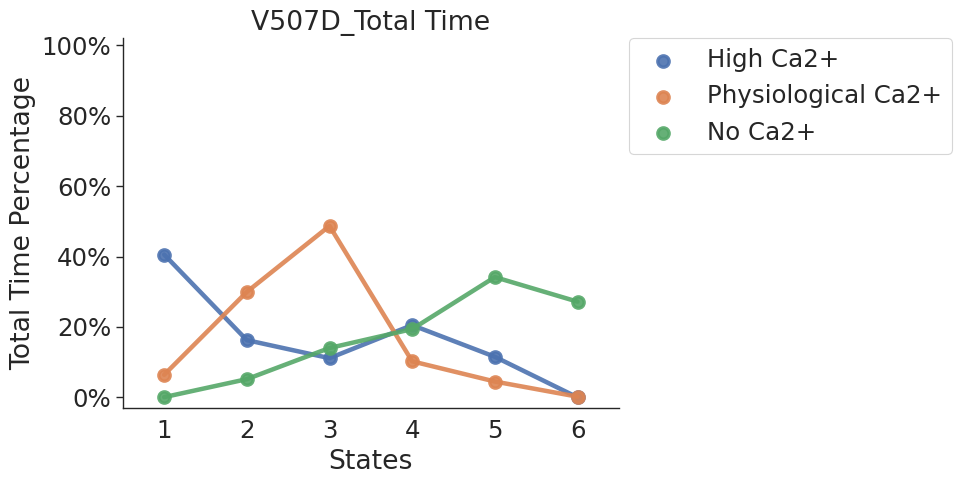

In [150]:
# Import All Time Data

f = pd.read_csv(f'{TimeSpent_Date}_Time_States.csv')

sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)  
sns.set_style('white', rc={
    'xtick.bottom': False,
    'ytick.left': True,
})

calcium=''
construct='V507D'
Time='Total'
ax=sns.pointplot(data=f[f['Construct']==construct], x='States', y=Time,hue='Ca Condition',scale=1.5)
plt.setp(ax.collections, alpha=.9)
plt.setp(ax.lines, alpha=.9)
plt.ylim(-0.03,1.02)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f'{construct}_{Time} Time')
plt.ylabel(f'{Time} Time Percentage')
sns.despine(top = True, right = True)

plt.savefig(f'DataTransfer/{construct}_{Time} Time.svg', format='svg', dpi=1200)

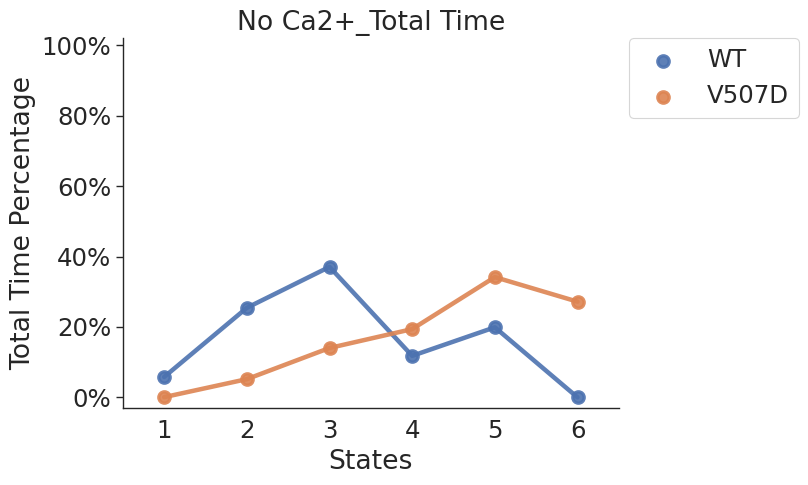

In [156]:
sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)  
sns.set_style('white', rc={
    'xtick.bottom': False,
    'ytick.left': True,
})

calcium='No Ca2+'
construct=''
Time='Total'
ax=sns.pointplot(data=f[f['Ca Condition']==calcium], x='States', y=Time, hue='Construct',scale=1.5)
plt.ylim(-0.03,1.02)
plt.setp(ax.collections, alpha=.9)
plt.setp(ax.lines, alpha=.9)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f'{calcium}_{Time} Time')
plt.ylabel(f'{Time} Time Percentage')
sns.despine(top = True, right = True)

plt.savefig(f'DataTransfer/{calcium}_{Time} Time.svg', format='svg', dpi=1200)

#### Time at different force

In [247]:
Force_Range = [(2.5,7.5),(7.5,12.5),(12.5,17.5),(17.5,22.5),(22.5,27.5),(27.5,32.5),(32.5,37.5)] #[(2,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35)]

df_time_force = pd.DataFrame(columns=['forcerange', 'time', 'state', 'PorR'])

forcerange=[]
time=[]
state=[]
PorR = []

for i in STATES_SEG_P.index:
    for j in range(6):
        if str(STATES_SEG_P[f'state_seg{j}'][i])!='nan':
            for fr in Force_Range:
                if min(STATES_SEG_P[f'seg{j}'][i].force.values)>fr[0] and max(STATES_SEG_P[f'seg{j}'][i].force.values)<fr[1]:
                    #print(1)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_P[f'seg{j}'][i].force.values))
                    state.append(STATES_SEG_P[f'state_seg{j}'][i])
                    PorR.append('Pull')
                    break
                elif min(STATES_SEG_P[f'seg{j}'][i].force.values)<fr[1] and min(STATES_SEG_P[f'seg{j}'][i].force.values)>fr[0] and max(STATES_SEG_P[f'seg{j}'][i].force.values)>fr[1]:
                    #print(2)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_P[f'seg{j}'][i].force.values[(STATES_SEG_P[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_P[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_P[f'state_seg{j}'][i])
                    PorR.append('Pull')
                elif max(STATES_SEG_P[f'seg{j}'][i].force.values)<fr[1] and min(STATES_SEG_P[f'seg{j}'][i].force.values)>fr[0] and min(STATES_SEG_P[f'seg{j}'][i].force.values)<fr[0]:
                    #print(3)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_P[f'seg{j}'][i].force.values[(STATES_SEG_P[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_P[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_P[f'state_seg{j}'][i])
                    PorR.append('Pull')
                elif max(STATES_SEG_P[f'seg{j}'][i].force.values)>fr[1] and min(STATES_SEG_P[f'seg{j}'][i].force.values)<fr[0]:
                    #print(4)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_P[f'seg{j}'][i].force.values[(STATES_SEG_P[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_P[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_P[f'state_seg{j}'][i])
                    PorR.append('Pull')

for i in STATES_SEG_R.index:
    for j in range(6):
        if str(STATES_SEG_R[f'state_seg{j}'][i])!='nan':
            for fr in Force_Range:
                if min(STATES_SEG_R[f'seg{j}'][i].force.values)>fr[0] and max(STATES_SEG_R[f'seg{j}'][i].force.values)<fr[1]:
                    #print(1)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_R[f'seg{j}'][i].force.values))
                    state.append(STATES_SEG_R[f'state_seg{j}'][i])
                    PorR.append('Release')
                    break
                elif min(STATES_SEG_R[f'seg{j}'][i].force.values)<fr[1] and min(STATES_SEG_R[f'seg{j}'][i].force.values)>fr[0] and max(STATES_SEG_R[f'seg{j}'][i].force.values)>fr[1]:
                    #print(2)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_R[f'seg{j}'][i].force.values[(STATES_SEG_R[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_R[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_R[f'state_seg{j}'][i])
                    PorR.append('Release')
                elif max(STATES_SEG_R[f'seg{j}'][i].force.values)<fr[1] and min(STATES_SEG_R[f'seg{j}'][i].force.values)>fr[0] and min(STATES_SEG_R[f'seg{j}'][i].force.values)<fr[0]:
                    #print(3)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_R[f'seg{j}'][i].force.values[(STATES_SEG_R[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_R[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_R[f'state_seg{j}'][i])
                    PorR.append('Release')
                elif max(STATES_SEG_R[f'seg{j}'][i].force.values)>fr[1] and min(STATES_SEG_R[f'seg{j}'][i].force.values)<fr[0]:
                    #print(4)
                    forcerange.append(fr)
                    time.append(len(STATES_SEG_R[f'seg{j}'][i].force.values[(STATES_SEG_R[f'seg{j}'][i].force.values>fr[0])&(STATES_SEG_R[f'seg{j}'][i].force.values<fr[1])]))
                    state.append(STATES_SEG_R[f'state_seg{j}'][i])
                    PorR.append('Release')

df_time_force['forcerange'] = forcerange
df_time_force['time'] = time
df_time_force['state'] = state
df_time_force['PorR'] = PorR

In [248]:
df_time_force['time (ms)'] = df_time_force['time']/100
df_time_force

,forcerange,time,state,PorR,time (ms)
0,"(2.5, 7.5)",2427,2,Pull,24.27
1,"(7.5, 12.5)",2599,2,Pull,25.99
2,"(12.5, 17.5)",2667,2,Pull,26.67
3,"(17.5, 22.5)",2804,2,Pull,28.04
4,"(22.5, 27.5)",2698,2,Pull,26.98
...,...,...,...,...,...
28554,"(12.5, 17.5)",2672,3,Release,26.72
28555,"(17.5, 22.5)",2670,3,Release,26.70
28556,"(22.5, 27.5)",2681,3,Release,26.81
28557,"(27.5, 32.5)",2924,3,Release,29.24


[0 1 2 3 4 5 6]


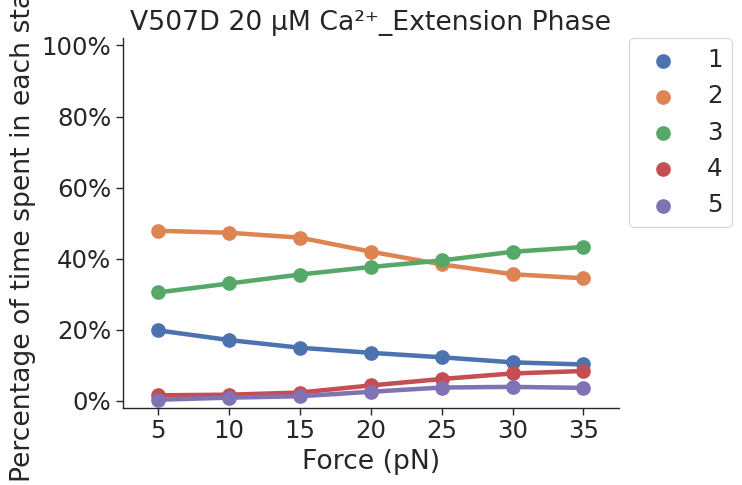

In [249]:
# Extension
df_time_force_perc = pd.DataFrame(columns=['Time percentage', 'Force range', 'State'])
df_time_force_pull = df_time_force[df_time_force['PorR']=='Pull']
tp = []
forcerange=[]
state=[]
for fr in Force_Range:
    totaltime = np.sum(df_time_force_pull['time'][df_time_force_pull['forcerange']==fr])
    for s in range(1,7):
        if np.sum(df_time_force_pull['time'][(df_time_force_pull['forcerange']==fr)&(df_time_force_pull['state']==s)])/totaltime>0:
            tp.append(np.sum(df_time_force_pull['time'][(df_time_force_pull['forcerange']==fr)&(df_time_force_pull['state']==s)])/totaltime)
            forcerange.append(fr)
            state.append(s)
df_time_force_perc['Time percentage'] = tp
df_time_force_perc['Force range'] = forcerange
df_time_force_perc['State'] = state


#plt.figure(figsize=(6,4))
sns.set_context("paper", font_scale=2)
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
ax=sns.pointplot(data=df_time_force_perc, x='Force range', y='Time percentage', hue='State', scale=1.5)
plt.title(f'{Condition}_Extension Phase')
plt.xlabel('Force (pN)')
plt.ylabel('Percentage of time spent in each state')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(-0.02,1.02)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
xt = ax.get_xticks()
ax.set_xticklabels([5,10,15,20,25,30,35])
print(xt)
sns.despine(top = True, right = True)

plt.savefig(f'DataTransfer/{Condition} Force Time.svg', format='svg', dpi=1200)



In [250]:
df_time_force_perc.to_csv(f'{Condition}forcetime.csv')

[0 1 2 3 4 5 6]


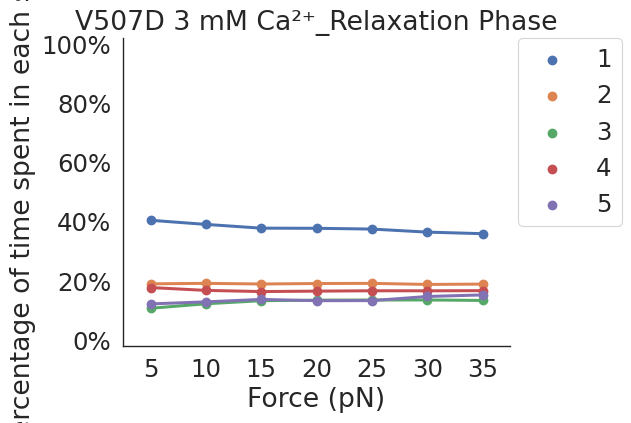

In [107]:
# Relaxation
df_time_force_perc = pd.DataFrame(columns=['Time percentage', 'Force range', 'State'])
df_time_force_release = df_time_force[df_time_force['PorR']=='Release']
tp = []
forcerange=[]
state=[]
for fr in Force_Range:
    totaltime = np.sum(df_time_force_release['time'][df_time_force_release['forcerange']==fr])
    for s in range(1,7):
        if np.sum(df_time_force_release['time'][(df_time_force_release['forcerange']==fr)&(df_time_force_release['state']==s)])/totaltime>0:
            tp.append(np.sum(df_time_force_release['time'][(df_time_force_release['forcerange']==fr)&(df_time_force_release['state']==s)])/totaltime)
            forcerange.append(fr)
            state.append(s)
df_time_force_perc['Time percentage'] = tp
df_time_force_perc['Force range'] = forcerange
df_time_force_perc['State'] = state
#df_time_force_perc

plt.figure(figsize=(5,4))
sns.set_context("paper", font_scale=2)
ax=sns.pointplot(data=df_time_force_perc, x='Force range', y='Time percentage', hue='State',palette=sns.color_palette())
plt.title(f'{Condition}_Relaxation Phase')
plt.xlabel('Force (pN)')
plt.ylabel('Percentage of time spent in each state')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(-0.02,1.02)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
xt = ax.get_xticks()
ax.set_xticklabels([5,10,15,20,25,30,35])
print(xt)
sns.despine(top = True, right = True)



#### Markov

In [ ]:
Force_Range = {'0-5 pN':(0,5),
              '5-10 pN':(5,10),
              '10-15 pN':(10,15),
              '15-20 pN':(15,20),
              '20-25 pN':(20,25),
              '25-30 pN':(25,30),
              '30-35 pN':(30,35),
              '35-40 pN':(35,40),
              '40-45 pN':(40,45),
              '45-50 pN':(45,50),
              '50-55 pN':(50,55),
              '55-60 pN':(55,60),
              '60-65 pN':(60,65),
              '65-70 pN':(65,70)}


Total_states = []
Total_trans_probs = []
Total_trans_probs_p38 = []

#for minforce in range(20,40):
    #maxforce = minforce+1
#for minforce in np.arange(5,50,2):
    #maxforce = minforce+2
for fr in list(Force_Range.keys()):
    minforce = Force_Range[fr][0]
    maxforce = Force_Range[fr][1]
    TIMESERIES = []
    for i in STATES_SEG_P.index:
        for j in range(6):
            if str(STATES_SEG_P[f'seg{j}'][i]) != 'nan':
                force = STATES_SEG_P[f'seg{j}'][i].force.values
                if (max(force) < minforce) or (min(force) >= maxforce):
                    continue
                elif (max(force) < maxforce) and (min(force) >= minforce):
                    TIMESERIES.append(int(len(force[(force>=minforce) & (force<maxforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])])
                elif (max(force) < maxforce) and (min(force) <= minforce):
                    if j == 5:
                        TIMESERIES.append(int(len(force[(force>=minforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])])
                    elif str(STATES_SEG_P[f'seg{j+1}'][i]) == 'nan':
                        TIMESERIES.append(int(len(force[(force>=minforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])])
                    else:
                        force_next = STATES_SEG_P[f'seg{j+1}'][i].force.values
                        t_former = int(len(force[(force>=minforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])]
                        t_next = int(len(force_next[(force_next<maxforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j+1}'][i])]
                        #print(t_former+t_next)
                        TIMESERIES.append(t_former+t_next)
                elif (max(force) > maxforce) and (min(force) >= minforce):
                    TIMESERIES.append(int(len(force[(force<maxforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])])
                elif (max(force) > maxforce) and (min(force) <= minforce):
                    TIMESERIES.append(int(len(force[(force>=minforce) & (force<maxforce)])*0.01)*[int(STATES_SEG_P[f'state_seg{j}'][i])])

    timeseries = TIMESERIES

    n_states = max(pd.Series([i for t in timeseries for i in t]).unique())
    Total_states.append(np.sort(pd.Series([i for t in timeseries for i in t]).unique()))
    # Initialize the transition count matrix
    trans_counts = np.zeros((n_states, n_states))

    # Count the number of transitions between states in the data
    for n in range(len(timeseries)):
        data = timeseries[n]
        #print(data)
        for i in range(len(data) - 1):
            curr_state = int(data[i])-1
            next_state = int(data[i+1])-1
            trans_counts[curr_state, next_state] += 1

    # Estimate the transition probabilities from the counts
    trans_probs = trans_counts / np.sum(trans_counts, axis=1, keepdims=True)
    Total_trans_probs.append(trans_probs)
    
    temp = np.zeros(trans_probs.shape)
    notnan_ind = ~np.isnan(trans_probs).any(axis=1)
    temp[~notnan_ind,:] = np.nan
    ind = np.arange(trans_probs.shape[0])[notnan_ind]
    temp[min(ind):max(ind)+1,min(ind):max(ind)+1] = np.linalg.matrix_power(trans_probs[notnan_ind, :][:, notnan_ind], 38)
    Total_trans_probs_p38.append(temp)
    
    # Print the Markov probability matrix
    print(f'Markov probability matrix _{Condition}_Pull_{fr}:')
    #print(f'Markov probability matrix _{Condition}_Pull_{minforce}-{maxforce} pN:')

    transind = []
    for i in range(1, max(pd.Series([i for t in timeseries for i in t]).unique()+1)):
        transind.append(f'state{i}')
    
    #print(pd.DataFrame(trans_probs, index=transind, columns=transind))
    print(pd.DataFrame(trans_probs, index=transind, columns=transind))

#### V507D 20uM

Text(0.5, 1.0, 'V507D 20uM Ca2+ State3 Transition')

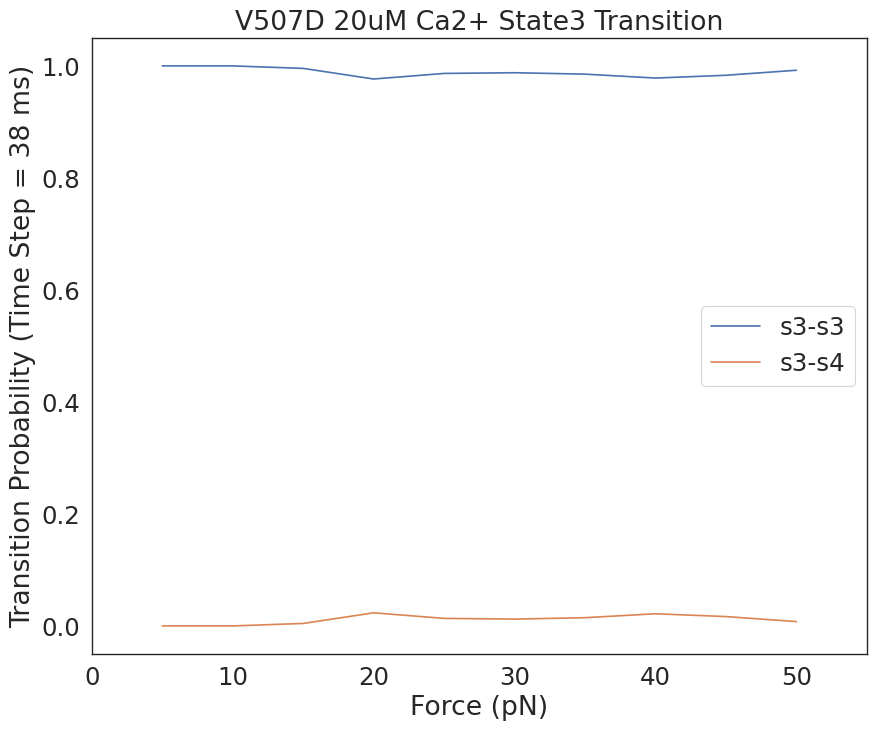

In [334]:
plt.figure(figsize=(10,8))

#V507D_20uM = Total_trans_probs_p38
V507D_20uM_plot = V507D_20uM[:-4]

CurrentState = 3

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,6):
        cs_ns = []
        for i in V507D_20uM_plot:
            if ns > i.shape[0]:
                break
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'V507D 20uM Ca2+ State{CurrentState} Transition')

Text(0.5, 1.0, 'V507D 20uM Ca2+ State Transition Size 2')

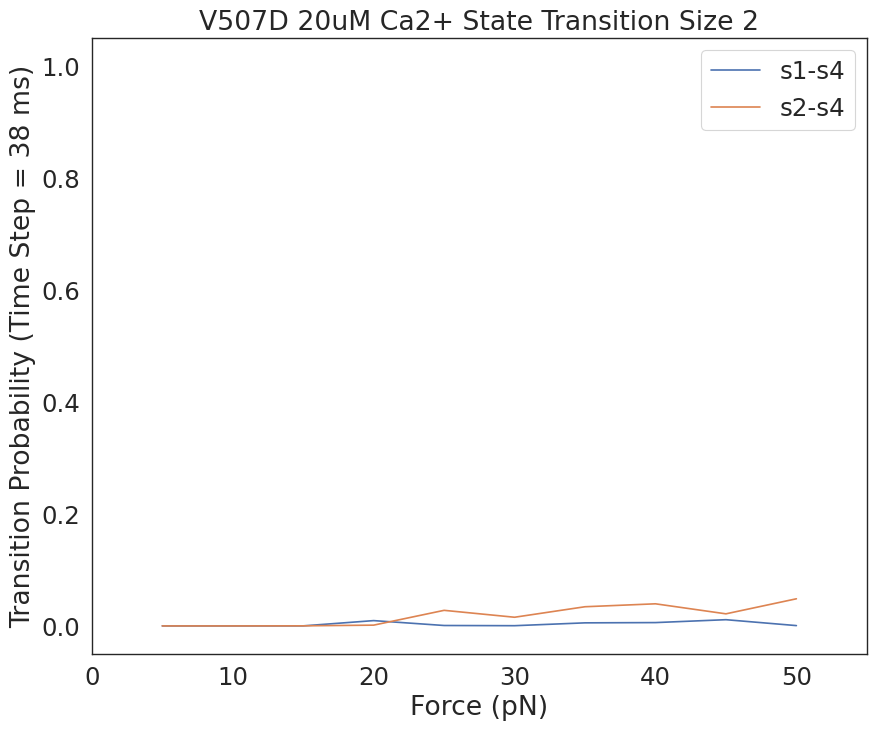

In [697]:
size=2

#V507D_20uM_size1 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))
#V507D_20uM_size2 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))    


plt.figure(figsize=(10,8))
for cs in range(1,6):
    if cs==1:
        ns=cs+1+size
    else:
        ns=cs+size
        
    cs_ns = []
    for i in V507D_20uM_plot:
        if ns > i.shape[0]:
            break
        cs_ns.append(i[cs-1,ns-1])
    sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')
    #if len(cs_ns)>0:
        #V507D_20uM_size2.iloc[cs-1]=cs_ns
    
plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'V507D 20uM Ca2+ State Transition Size {size}')

#### V507D 3mM

Text(0.5, 1.0, 'V507D 3mM Ca2+ State3 Transition')

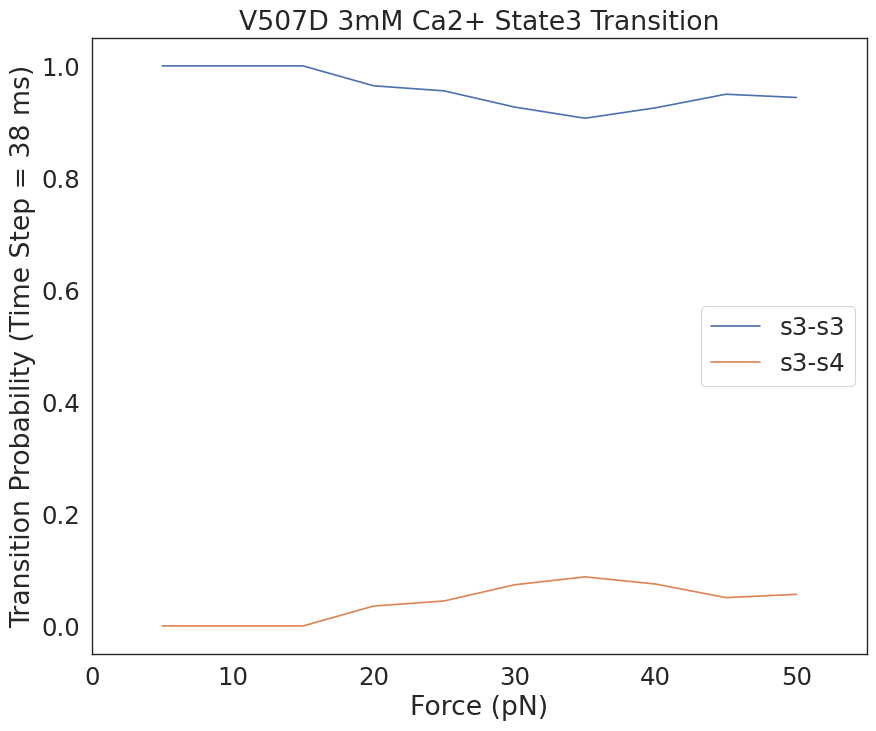

In [982]:
plt.figure(figsize=(10,8))

#V507D_3mM = Total_trans_probs_p38
V507D_3mM_plot = V507D_3mM[:-4]

CurrentState = 3

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,6):
        cs_ns = []
        for i in V507D_3mM_plot:
            if ns > i.shape[0]:
                break
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'V507D 3mM Ca2+ State{CurrentState} Transition')

Text(0.5, 1.0, 'V507D 3mM Ca2+ State Transition Size 1')

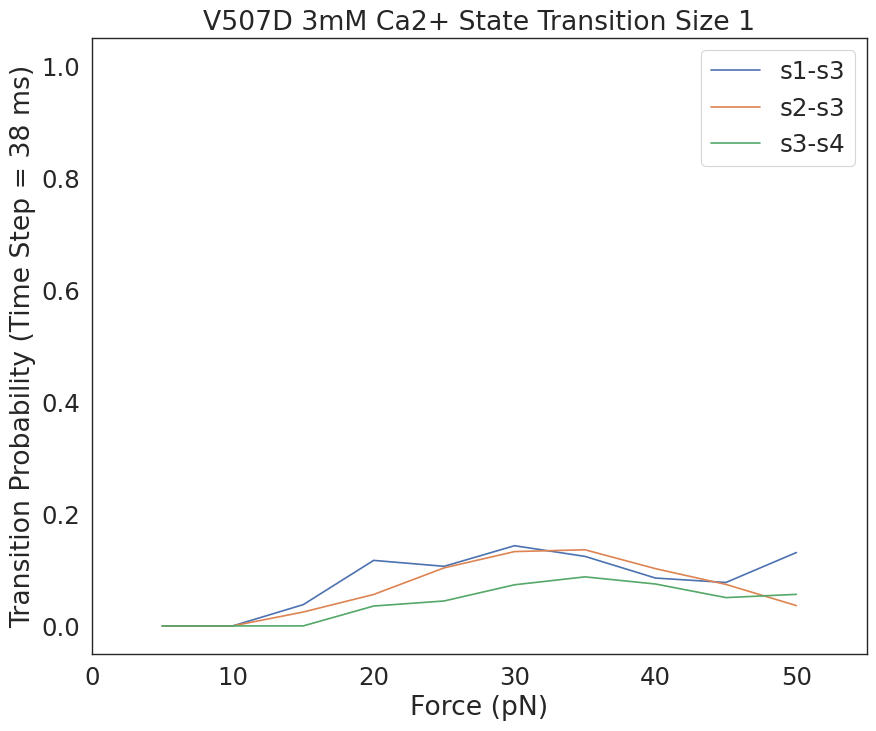

In [695]:
size=1

#V507D_3mM_size1 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))
#V507D_3mM_size2 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))    


plt.figure(figsize=(10,8))
for cs in range(1,6):
    if cs==1:
        ns=cs+1+size
    else:
        ns=cs+size
        
    cs_ns = []
    for i in V507D_3mM_plot:
        if ns > i.shape[0]:
            break
        cs_ns.append(i[cs-1,ns-1])
    sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')
    #if len(cs_ns)>0:
        #V507D_3mM_size2.iloc[cs-1]=cs_ns
        
plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'V507D 3mM Ca2+ State Transition Size {size}')

#### WT 3mM

Text(0.5, 1.0, 'WT 3mM Ca2+ State2 Transition')

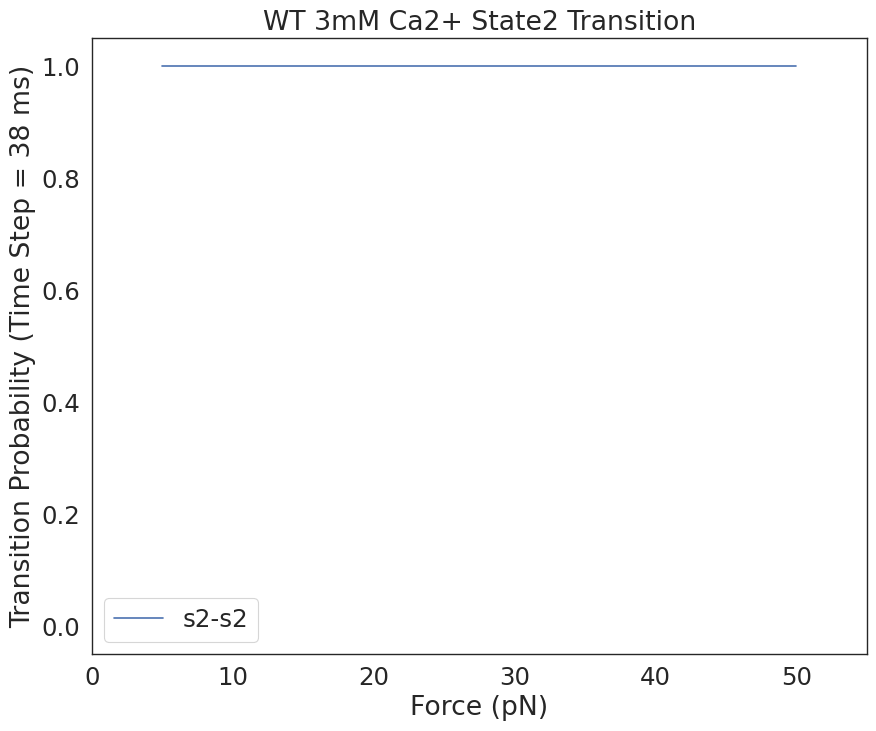

In [306]:
plt.figure(figsize=(10,8))

#WT_3mM = Total_trans_probs_p38
WT_3mM_plot = WT_3mM[:-1]

CurrentState = 2

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,6):
        cs_ns = []
        for i in WT_3mM_plot:
            if ns > i.shape[0]:
                break
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'WT 3mM Ca2+ State{CurrentState} Transition')

#### WT 20uM

Text(0.5, 1.0, 'WT 20uM Ca2+ State2 Transition')

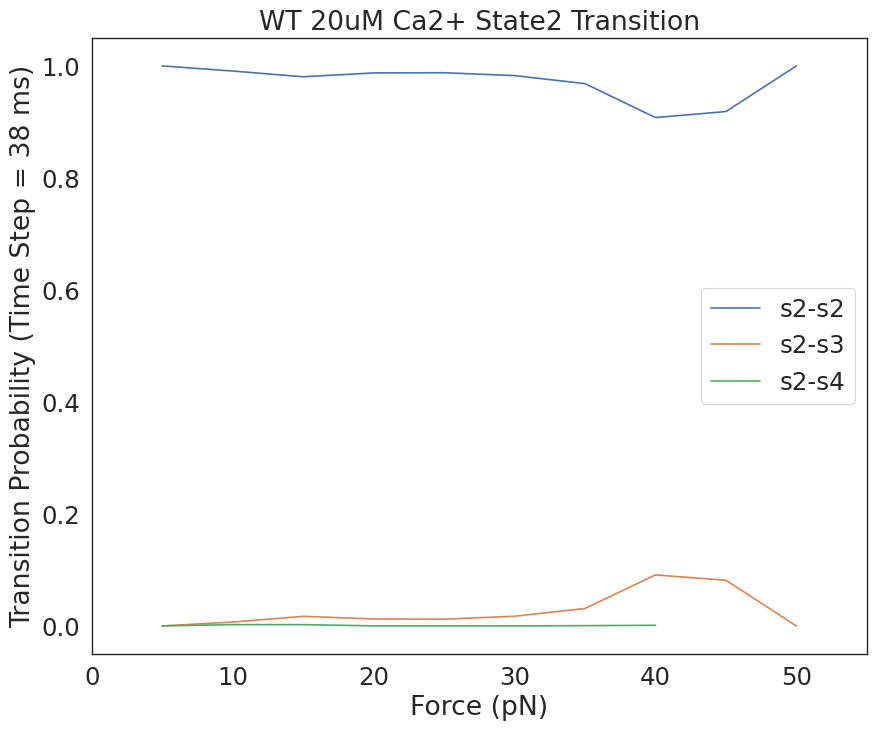

In [310]:
plt.figure(figsize=(10,8))

#WT_20uM = Total_trans_probs_p38
WT_20uM_plot = WT_20uM[:-2]

CurrentState = 

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,6):
        cs_ns = []
        for i in WT_20uM_plot:
            if ns > i.shape[0]:
                break
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.title(f'WT 20uM Ca2+ State{CurrentState} Transition')

Text(0.5, 1.0, 'WT 20uM Ca2+ State Transition Size 1')

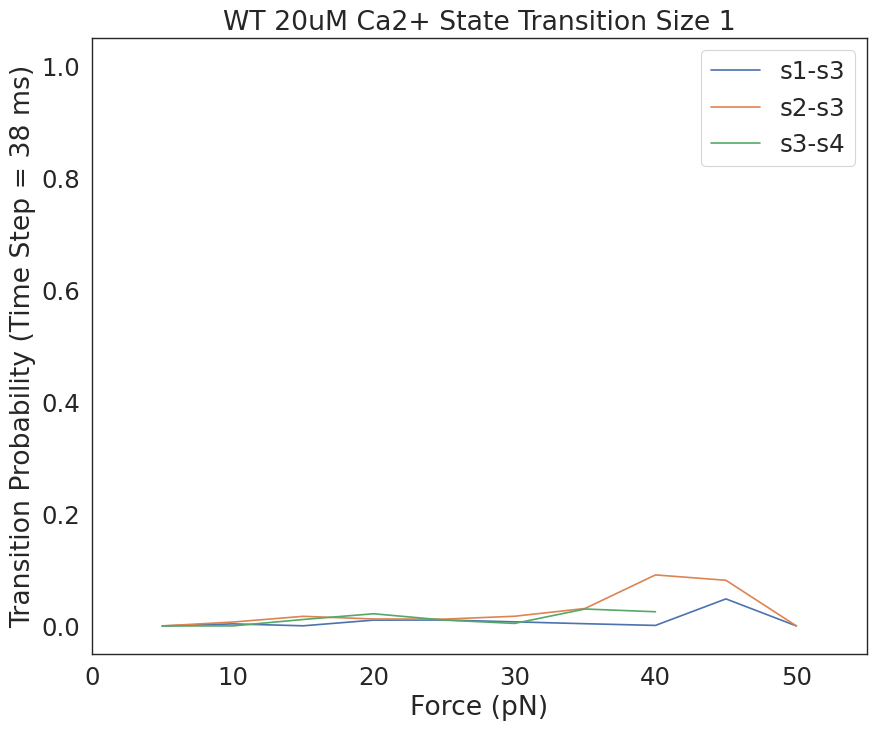

In [704]:
size=1

#WT_20uM_size1 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))
#WT_20uM_size2 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))    


plt.figure(figsize=(10,8))
for cs in range(1,6):
    if cs==1:
        ns=cs+1+size
    else:
        ns=cs+size
        
    cs_ns = []
    for i in WT_20uM_plot:
        if ns > i.shape[0]:
            break
        cs_ns.append(i[cs-1,ns-1])
    sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')
    #if len(cs_ns)>0:
        #WT_20uM_size2.iloc[cs-1][WT_20uM_size2.columns[:len(cs_ns)]]=cs_ns
    
plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'WT 20uM Ca2+ State Transition Size {size}')

#### V507D 0M

Text(0.5, 1.0, 'V507D 0M Ca2+ State3 Transition')

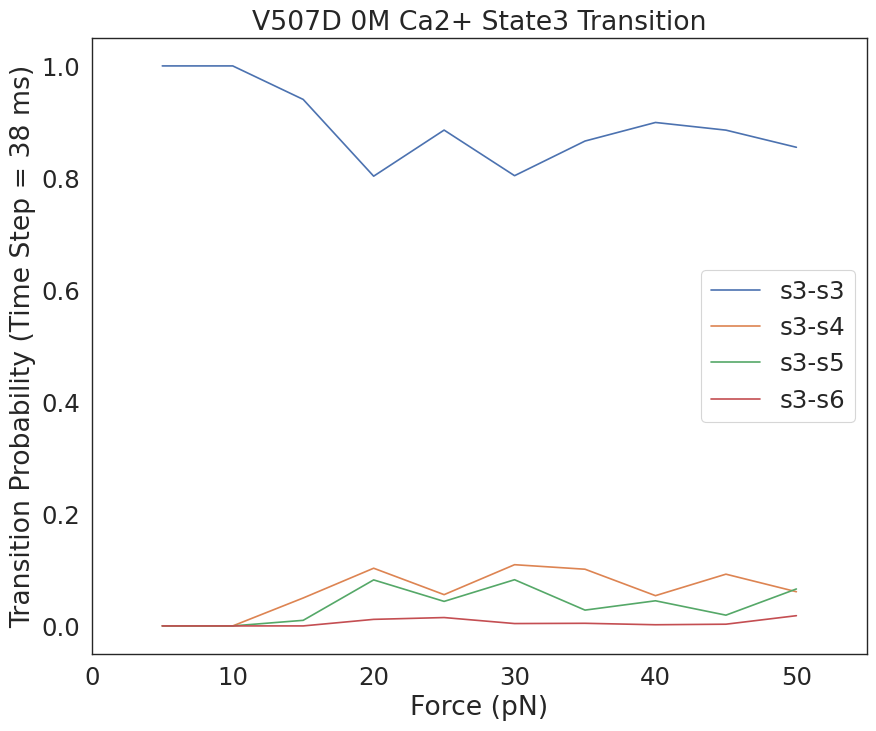

In [983]:
plt.figure(figsize=(10,8))

#V507D_0M = Total_trans_probs_p38
V507D_0M_plot = V507D_0M[:-3]

CurrentState = 3

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,7):
        cs_ns = []
        for i in V507D_0M_plot:
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.title(f'V507D 0M Ca2+ State{CurrentState} Transition')

Text(0.5, 1.0, 'V507D 0M Ca2+ State Transition Size 1')

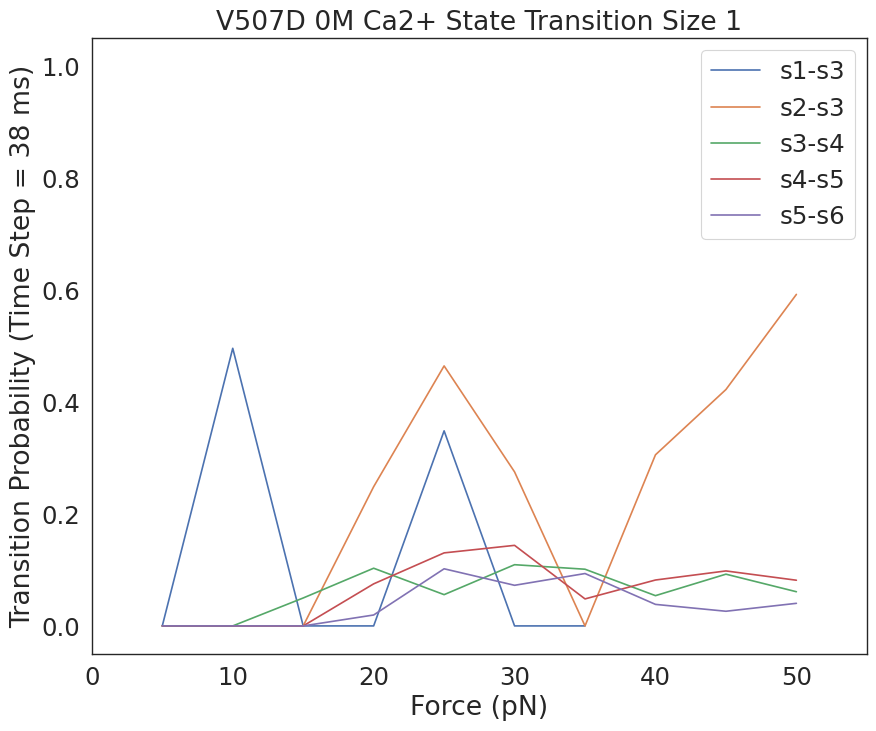

In [688]:
size=1
#V507D_0M_size1 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))
#V507D_0M_size2 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))

plt.figure(figsize=(10,8))
for cs in range(1,6):
    if cs==1:
        ns=cs+1+size
    else:
        ns=cs+size
        
    cs_ns = []
    for i in V507D_0M_plot:
        if ns > i.shape[0]:
            break
        cs_ns.append(i[cs-1,ns-1])
    sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')
    #V507D_0M_size2.iloc[cs-1]=cs_ns

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'V507D 0M Ca2+ State Transition Size {size}')

#### WT 0M

Text(0.5, 1.0, 'WT 0M Ca2+ State3 Transition')

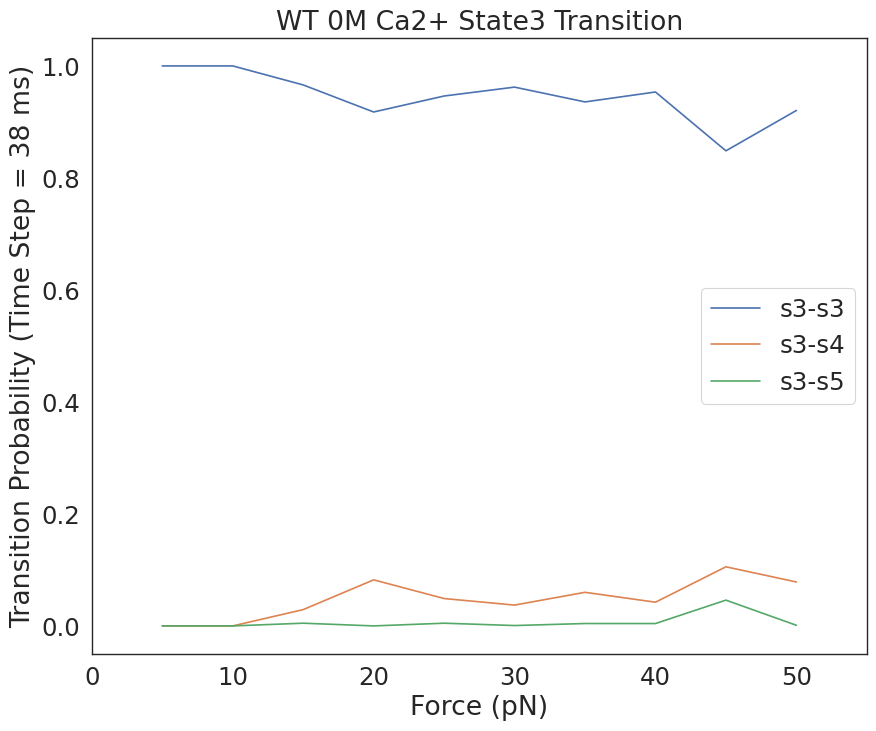

In [984]:
plt.figure(figsize=(10,8))

#WT_0M = Total_trans_probs_p38
WT_0M_plot = WT_0M[:-2]

CurrentState = 3

for cs in range(CurrentState,CurrentState+1):
    for ns in range(cs,6):
        cs_ns = []
        for i in WT_0M_plot:
            if ns > i.shape[0]:
                break
            cs_ns.append(i[cs-1,ns-1])
        sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.title(f'WT 0M Ca2+ State{CurrentState} Transition')

Text(0.5, 1.0, 'WT 0M Ca2+ State Transition Size 1')

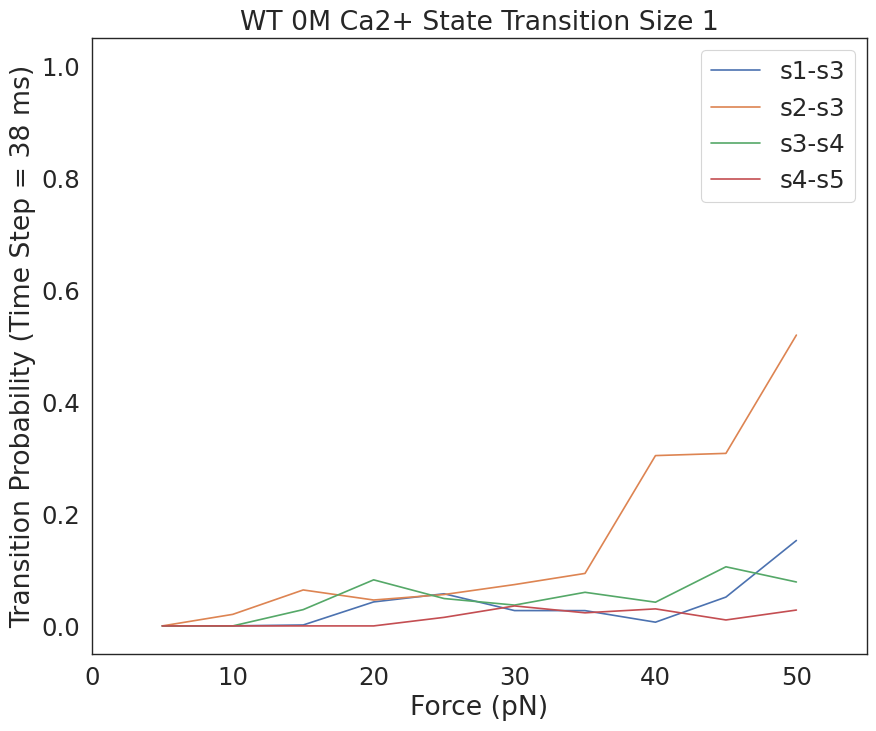

In [693]:
size=1

#WT_0M_size1 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))
#WT_0M_size2 = pd.DataFrame(columns=np.arange(5,55,5),index=range(10))

plt.figure(figsize=(10,8))
for cs in range(1,6):
    if cs==1:
        ns=cs+1+size
    else:
        ns=cs+size
        
    cs_ns = []
    for i in WT_0M_plot:
        if ns > i.shape[0]:
            break
        cs_ns.append(i[cs-1,ns-1])
    sns.lineplot(x=np.arange(5,70,5)[:len(cs_ns)], y=cs_ns, label=f's{cs}-s{ns}')
    #if len(cs_ns)>0:
        #WT_0M_size2.iloc[cs-1]=cs_ns

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability (Time Step = 38 ms)')
plt.xlim(0,55)
plt.ylim(-0.05,1.05)
plt.title(f'WT 0M Ca2+ State Transition Size {size}')

#### plot state transition probability based on size

Text(0.5, 1.0, '20uM size1')

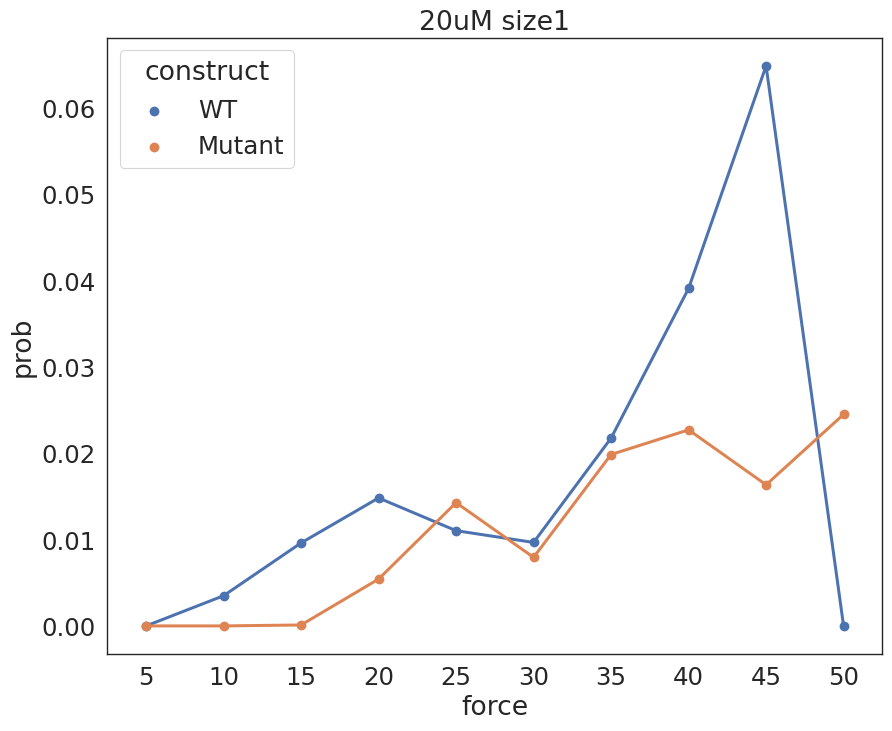

In [981]:
def transform_size(df,ca,cons):
    df = df.dropna(how='all')
    tdf = pd.DataFrame(columns=['prob','force','Ca2+','construct'])
    force=[]
    prob=[]
    for i in df.index:
        for j in df.columns:
            if str(df[j][i])!='nan':
                force.append(j)
                prob.append(df[j][i])
    tdf['prob'] = prob
    tdf['force'] = force
    tdf['Ca2+'] = ca
    tdf['construct'] = cons
    
    return tdf

t_WT_20uM_size1 = transform_size(WT_20uM_size1, '20uM','WT')
t_WT_0M_size1 = transform_size(WT_0M_size1, '0M','WT')
t_V507D_3mM_size1 = transform_size(V507D_3mM_size1, '3mM','Mutant')
t_V507D_20uM_size1 = transform_size(V507D_20uM_size1, '20uM','Mutant')
t_V507D_0M_size1 = transform_size(V507D_0M_size1, '0M','Mutant')

t_WT_3mM_size1 = transform_size(WT_20uM_size1, '20uM','WT')
t_WT_3mM_size1['prob']=0
t_WT_3mM_size1['Ca2+']='3mM'


plot_size1 = pd.concat([t_WT_3mM_size1,t_WT_20uM_size1,t_WT_0M_size1,t_V507D_3mM_size1,t_V507D_20uM_size1,t_V507D_0M_size1])

plt.figure(figsize=(10,8))
sns.pointplot(data=plot_size1[plot_size1['Ca2+']=='20uM'], x='force',y='prob',hue='construct', errorbar=None)
plt.title('20uM size1')

### Other plotting

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
s1_s1_WT0M = []
for i in WT_0M_plot:
    s1_s1_WT0M.append(i[0][0])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_WT0M)], y=s1_s1_WT0M, label='WT_0M Ca\u00b2\u207a')

s1_s1_V507D3mM = []
for i in V507D_3mM_plot:
    s1_s1_V507D3mM.append(i[0][0])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D3mM)], y=s1_s1_V507D3mM, label='V507D_3mM Ca\u00b2\u207a')

s1_s1_V507D20uM = []
for i in V507D_20uM_plot:
    s1_s1_V507D20uM.append(i[0][0])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D20uM)], y=s1_s1_V507D20uM, label='V507D_20\u03BCM Ca\u00b2\u207a')

s1_s1_V507D0M = []
for i in V507D_0M_plot:
    s1_s1_V507D0M.append(i[0][0])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D0M)], y=s1_s1_V507D0M, label='V507D_0M Ca\u00b2\u207a')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability')
plt.title('State1 to State1')

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(10,8))
s1_s1_WT0M = []
for i in WT_0M_plot:
    s1_s1_WT0M.append(i[2][2])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_WT0M)], y=s1_s1_WT0M, label='WT_0M Ca\u00b2\u207a')

s1_s1_V507D3mM = []
for i in V507D_3mM_plot[:-1]:
    s1_s1_V507D3mM.append(i[2][2])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D3mM)], y=s1_s1_V507D3mM, label='V507D_3mM Ca\u00b2\u207a')

s1_s1_V507D20uM = []
for i in V507D_20uM_plot:
    s1_s1_V507D20uM.append(i[2][2])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D20uM)], y=s1_s1_V507D20uM, label='V507D_20\u03BCM Ca\u00b2\u207a')

s1_s1_V507D0M = []
for i in V507D_0M_plot:
    s1_s1_V507D0M.append(i[2][2])
sns.lineplot(x=np.linspace(5,70,14)[:len(s1_s1_V507D0M)], y=s1_s1_V507D0M, label='V507D_0M Ca\u00b2\u207a')

plt.xlabel('Force (pN)')
plt.ylabel('Transition Probability')
plt.legend(loc='lower right')
plt.title('State3 to State3')

In [ ]:
s1_s1 = []
for i in (Total_trans_probs):
    s1_s1.append(np.linalg.matrix_power(i, 1000)[0][0])
sns.lineplot(x=np.arange(20,40), y=s1_s1)

In [ ]:
"""timeseries = []
for i in df_time.index:
    t = []
    for j in range(1,5):
        if df_time[f'state{j}'][i] != 0:
            t += [j]*df_time[f'state{j}'][i]
    timeseries.append(t)
timeseries = np.asarray(timeseries)"""

In [ ]:

assert np.allclose(np.sum(trans_probs, axis=1), np.ones(n_states))


f = 3
#print(list(Force_Range.keys())[f])
n_states = 5#Total_states[f]
trans_probs = V507D_0M_plot[3]#Total_trans_probs[f]


# Create a Pydot graph object
graph = pydot.Dot(graph_type='digraph')

# Add the nodes to the graph
for i in range(n_states):
    node = pydot.Node(str(i+1))
    graph.add_node(node)

# Add the edges to the graph
for i in range(n_states):
    for j in range(n_states):
        weight = trans_probs[i, j]
        if weight > 0:
            edge = pydot.Edge(str(i+1), str(j+1), label='{:.4f}'.format(weight))
            graph.add_edge(edge)
graph.write_png('markov_chain.png')
Image(filename='markov_chain.png')

### Rupture Force Analysis

In [1108]:
RuptureForce = pd.DataFrame(columns=['s1-s1', 's1-s2', 's1-s3','s1-s4','s1-s5','s1-s6',
                                     's2-s2','s2-s3','s2-s4','s2-s5','s2-s6',
                                     's3-s3','s3-s4','s3-s5','s3-s6',
                                     's4-s4', 's4-s5','s4-s6',
                                     's5-s5','s5-s6',
                                     's6-s6'], index=STATES_SEG_P.index)

for i in STATES_SEG_P.index:
    for j in range(5):
        if str(STATES_SEG_P[f'state_seg{j}'][i]) != 'nan' and str(STATES_SEG_P[f'state_seg{j+1}'][i]) != 'nan':
            fs = STATES_SEG_P[f'state_seg{j}'][i]
            ls = STATES_SEG_P[f'state_seg{j+1}'][i]
            if fs>ls:
                continue
            else:
                RuptureForce[f's{fs}-s{ls}'][i] = STATES_SEG_P[f'seg{j}'][i].force.values[-1]
        else:
            continue


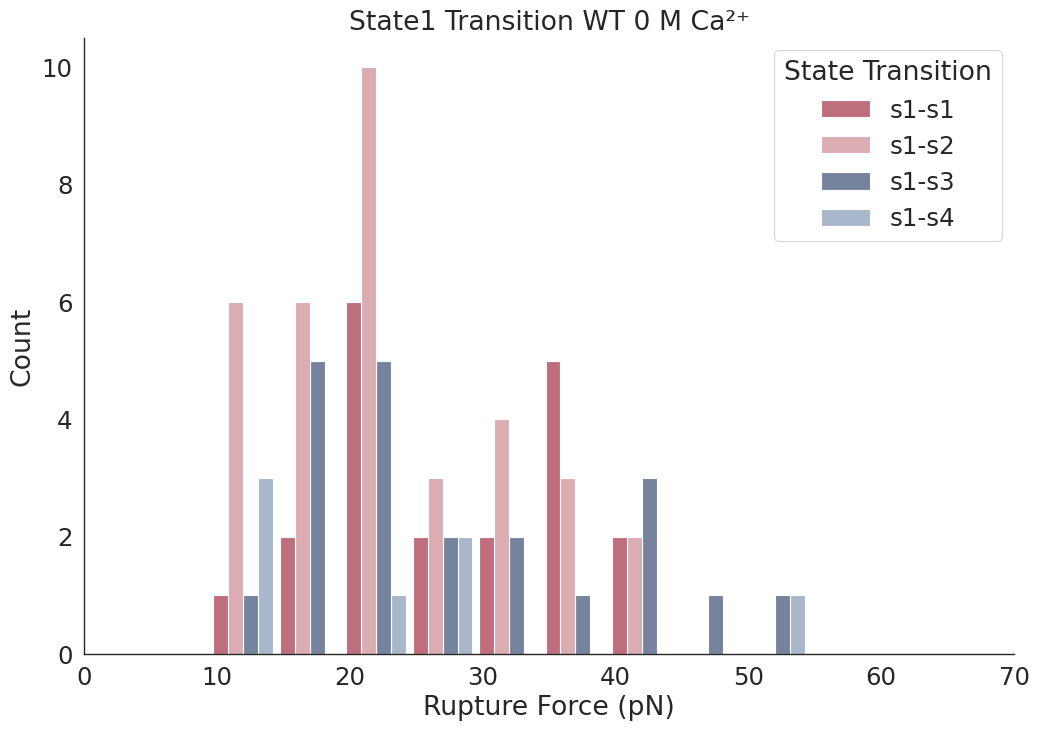

In [1109]:
RF = pd.DataFrame(columns=['Rupture Force', 'State Transition'])
rf = []
st = []

S1 = ['s1-s1', 's1-s2', 's1-s3','s1-s4','s1-s5','s1-s6']
S1_c = ['#aa3e53','#cf9198','#48597e','#8d9fbb','#c1c2d2','#c6d7e3']#
S2 = ['s2-s2','s2-s3','s2-s4','s2-s5','s2-s6']
S3 = ['s3-s3','s3-s4','s3-s5','s3-s6']
S4 = ['s4-s4', 's4-s5','s4-s6']
S5 = ['s5-s5','s5-s6']
S6 = ['s6-s6']
S2_6_c = ['#aa3e53','#48597e','#8d9fbb','#c1c2d2','#c6d7e3']

statedic = {1:S1, 2:S2, 3:S3, 4:S4, 5:S5, 6:S6}
cdic = {1:S1_c, 2:S2_6_c, 3:S2_6_c, 4:S2_6_c, 5:S2_6_c, 6:S2_6_c}

statei = 1


for i in RuptureForce.index:
    for j in statedic[statei]:
        if str(RuptureForce[j][i]) != 'nan':
            rf.append(RuptureForce[j][i])
            st.append(j)
RF['Rupture Force'] = rf
RF['State Transition'] = st

RF = RF.sort_values(by=['State Transition'])

sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)    
plt.figure(figsize=(12,8))
ax=sns.histplot(data=RF, x='Rupture Force', hue='State Transition',multiple="dodge", shrink=0.9, binwidth=5, palette=cdic[statei])

plt.xlim(0,70)
plt.xlabel('Rupture Force (pN)')
plt.title(f'State{statei} Transition {Condition}')
sns.despine(top = True, right = True)
sns.move_legend(ax, "upper right")#, bbox_to_anchor=(1, 1)

n= 314


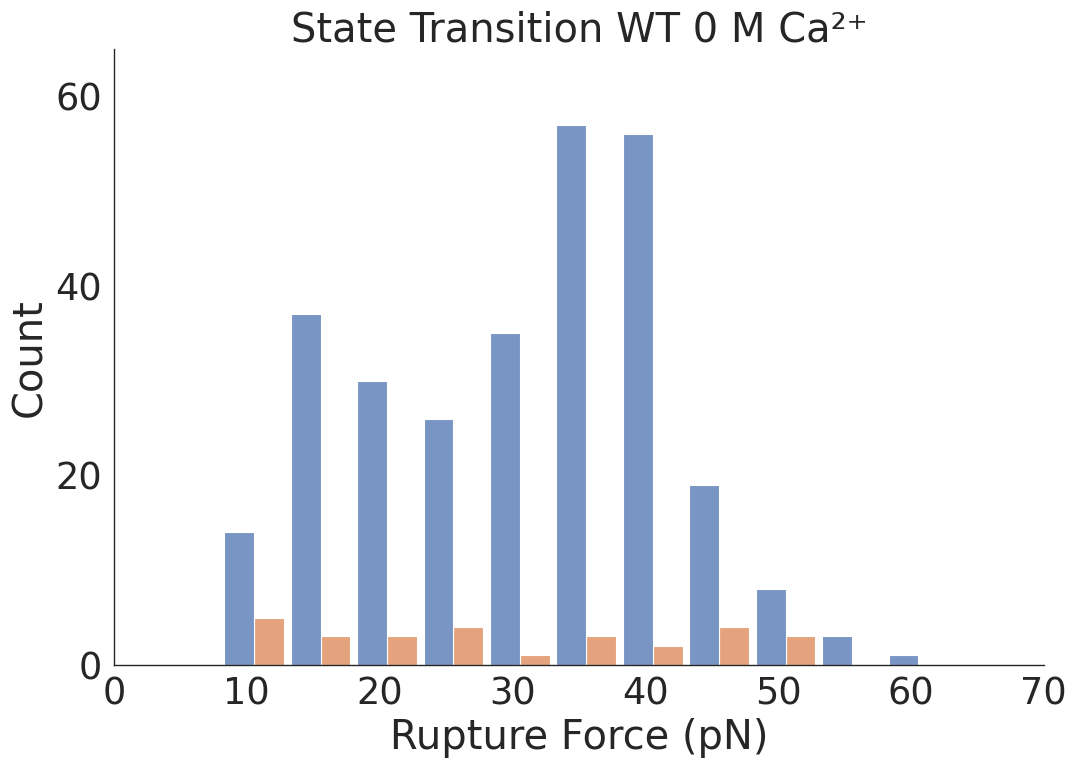

In [1114]:
RF_size = pd.DataFrame(columns=['Rupture Force', 'State Transition'])
rf = []
st = []

size1 = ['s1-s3','s2-s3','s3-s4','s4-s5']
size2 = ['s1-s4','s2-s4','s3-s5','s4-s6']




for i in RuptureForce.index:
    for j in RuptureForce.columns:
        if str(RuptureForce[j][i]) != 'nan':
            if j in size1:
                rf.append(RuptureForce[j][i])
                st.append('Transition Size = 1')
            elif j in size2:
                rf.append(RuptureForce[j][i])
                st.append('Transition Size = 2')              
RF_size['Rupture Force'] = rf
RF_size['State Transition'] = st

RF_size = RF_size.sort_values(by=['State Transition'])

sns.set_theme(style='white')
sns.set_context("paper", font_scale=3)    
plt.figure(figsize=(12,8))
ax=sns.histplot(data=RF_size, x='Rupture Force', hue='State Transition',multiple="dodge", shrink=0.9, binwidth=5,legend=False)

plt.xlim(0,70)
plt.xlabel('Rupture Force (pN)')
plt.title(f'State Transition {Condition}')
sns.despine(top = True, right = True)
#sns.move_legend(ax, "upper right")#, bbox_to_anchor=(1, 1)
plt.ylim(0,65)
plt.yticks([0,20,40,60])
#plt.ylabel('Percentage (%)')
#sns.move_legend(ax, "upper right")
print('n=',len(RF_size.index))

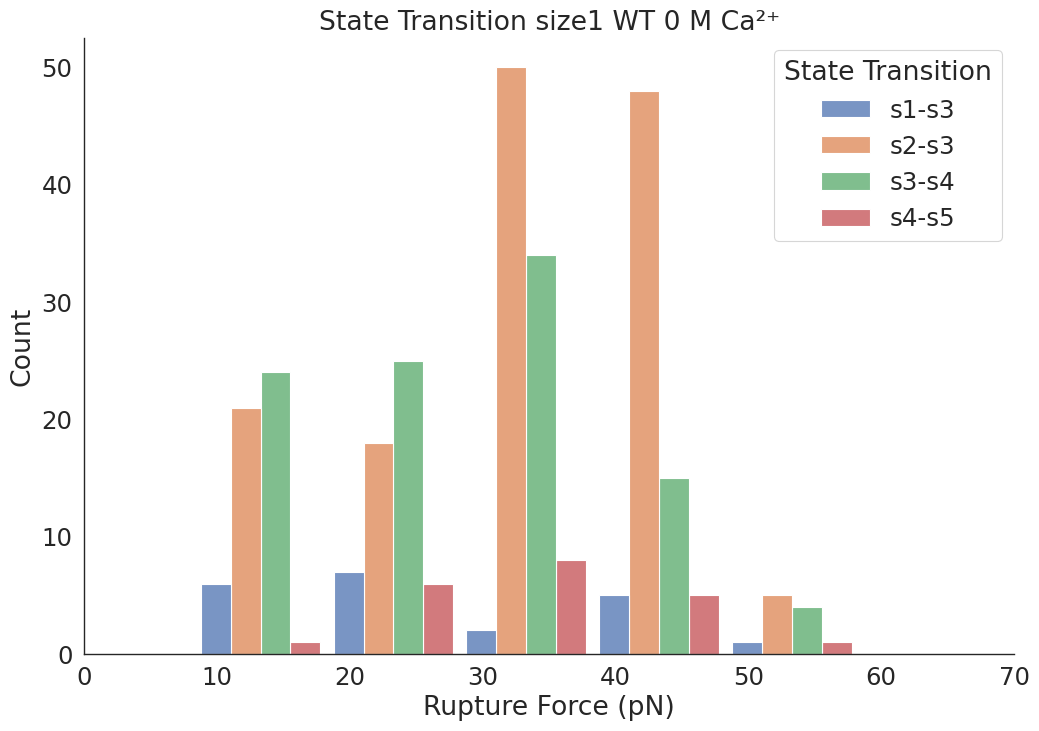

In [1111]:
size=1

RF_size = pd.DataFrame(columns=['Rupture Force', 'State Transition'])
rf = []
st = []

size1 = ['s1-s3','s2-s3','s3-s4','s4-s5']
size2 = ['s1-s4','s2-s4','s3-s5','s4-s6']




for i in RuptureForce.index:
    if size == 1:
        for j in size1:
            if str(RuptureForce[j][i]) != 'nan':
                st.append(j) 
                rf.append(RuptureForce[j][i])
                
RF_size['Rupture Force'] = rf
RF_size['State Transition'] = st

RF_size = RF_size.sort_values(by=['State Transition'])

sns.set_theme(style='white')
sns.set_context("paper", font_scale=2)    
plt.figure(figsize=(12,8))
ax=sns.histplot(data=RF_size, x='Rupture Force', hue='State Transition',multiple="dodge", shrink=0.9, binwidth=10)

plt.xlim(0,70)
plt.xlabel('Rupture Force (pN)')
plt.title(f'State Transition size{size} {Condition}')
sns.despine(top = True, right = True)
sns.move_legend(ax, "upper right")#, bbox_to_anchor=(1, 1)
#plt.ylim(0,60)

### Refold force

In [1030]:
RefoldForce = pd.DataFrame(columns=['s3-s1', 's4-s1', 's5-s1','s6-s1',
                                     's3-s2','s4-s2','s5-s2','s6-s2',
                                     's4-s3','s5-s3','s6-s3',
                                     's5-s4', 's6-s4',
                                     's6-s5'], index=STATES_SEG_R.index)

for i in STATES_SEG_R.index:
    for j in np.arange(1,6)[::-1]:
        if str(STATES_SEG_R[f'state_seg{j}'][i]) != 'nan' and str(STATES_SEG_R[f'state_seg{j-1}'][i]) != 'nan':
            fs = STATES_SEG_R[f'state_seg{j}'][i]
            ls = STATES_SEG_R[f'state_seg{j-1}'][i]
            if fs<=ls:
                continue
            if fs==2 and ls==1:
                continue
            else:
                print(STATES_SEG_R[f'seg{j}'][i].force.values)
                RefoldForce[f's{fs}-s{ls}'][i] = STATES_SEG_R[f'seg{j}'][i].force.values[0]
        else:
            continue

[27.60834311 27.60592005 27.60226169 ...  2.01073057  2.00620289
  2.00145592]


In [1031]:
RefoldForce.dropna(how='all')

,s3-s1,s4-s1,s5-s1,s6-s1,s3-s2,s4-s2,s5-s2,s6-s2,s4-s3,s5-s3,s6-s3,s5-s4,s6-s4,s6-s5
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.608343,NaN,NaN,NaN,NaN,NaN


### Comparing Accuracy

In [ ]:
Acc_FileName = 'Results/accuracy_2022-12-19_s1b2_V507Ddimer 0MCa_across_datasets'

# Results/accuracy_2022-05-03_s0b1_cyscysdimer_0MCa_across_datasets
# Results/accuracy_2022-10-18_s1b1_V507D Dimer 3mM Ca_across_datasets_dev4
# Results/accuracy_2022-12-19_s1b2_V507Ddimer 0MCa_across_datasets

In [ ]:
Accuracy= pd.read_csv(f'{Acc_FileName}.csv', index_col=[0])
np.mean(Accuracy)

In [ ]:
Acc_FileName_compare = 'Results/accuracy_2022-12-19_s1b2_V507Ddimer 0MCa_distance*1.3'
Accuracy_compare= pd.read_csv(f'{Acc_FileName_compare}.csv', index_col=[0])
np.mean(Accuracy_compare)